In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import celeri

# Read data and pre-process

In [3]:
COMMAND_FILE_NAME = "../data/command/japan_command_cmi_coupling.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

INFO: Read: ../data/command/japan_command_cmi_coupling.json - celeri.celeri:get_logger:7560 - 2024-11-13 18:26:59
INFO: RUN_NAME: 0000000504 - celeri.celeri:get_logger:7561 - 2024-11-13 18:26:59
INFO: Write log file: ../runs/0000000504/0000000504.log - celeri.celeri:get_logger:7562 - 2024-11-13 18:26:59
INFO: Reading data files - celeri.celeri:read_data:451 - 2024-11-13 18:26:59
SUCCESS: Read: ../data/segment/qp_japan_segment.csv - celeri.celeri:read_data:455 - 2024-11-13 18:26:59
SUCCESS: Read: ../data/block/japan_block.csv - celeri.celeri:read_data:460 - 2024-11-13 18:26:59
SUCCESS: Read: ../data/mesh/japan_mesh_parameters_cmi_coupling.json - celeri.celeri:read_data:467 - 2024-11-13 18:26:59

SUCCESS: Read: ../data/mesh/nankai.msh - celeri.celeri:read_mesh:446 - 2024-11-13 18:26:59

SUCCESS: Read: ../data/mesh/japan.msh - celeri.celeri:read_mesh:446 - 2024-11-13 18:26:59

SUCCESS: Read: ../data/mesh/sagami.msh - celeri.celeri:read_mesh:446 - 2024-11-13 18:26:59

SUCCESS: Read: ../dat

# Generate all operators, weighting, and data vector for KL+QP problem

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = celeri.get_index_eigen(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = celeri.get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = celeri.get_weighting_vector_eigen(
    command, station, meshes, index
)

# Get KL modes for each mesh
celeri.get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = celeri.get_full_dense_operator_eigen(operators, meshes, index)

# Get rotation to TDE kinematic slip rate operator for all meshes tied to segments
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

INFO: Computing elastic operators - celeri.celeri:get_elastic_operators:2053 - 2024-11-13 18:26:59


Calculating Okada partials for segments: 100%|██████████| 481/481 [00:04<00:00, 106.88it/s]


INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-13 18:27:04


Calculating cutde partials for triangles: 100%|██████████| 1902/1902 [00:05<00:00, 318.05it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-13 18:27:10
INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-13 18:27:10


Calculating cutde partials for triangles: 100%|██████████| 2621/2621 [00:07<00:00, 327.90it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-13 18:27:18
INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-13 18:27:18


Calculating cutde partials for triangles: 100%|██████████| 231/231 [00:00<00:00, 274.02it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-13 18:27:19
INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-13 18:27:19


Calculating cutde partials for triangles: 100%|██████████| 76/76 [00:00<00:00, 317.93it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-13 18:27:19
INFO: No slip rate constraints - celeri.celeri:get_slip_rate_constraints:3356 - 2024-11-13 18:27:20
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-11-13 18:27:20
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-11-13 18:27:21
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-11-13 18:27:21
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-11-13 18:27:23
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-11-13 18:27:23
SUCCESS: Finish: 

# Solve bounded KL+QP problem

In [5]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    celeri.get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

INFO: No hard slip rate bounds - celeri.celeri:get_slip_rate_bounds:4153 - 2024-11-13 18:27:24
     pcost       dcost       gap    pres   dres
 0: -2.9918e+04 -3.4698e+07  3e+07  2e-17  1e-15
 1: -4.4283e+04 -8.3736e+06  8e+06  3e-16  5e-16
 2: -4.4007e+04 -7.9964e+06  8e+06  3e-16  6e-16
 3: -4.4313e+04 -1.4707e+06  1e+06  3e-16  6e-16
 4: -4.6928e+04 -2.3545e+05  2e+05  3e-16  5e-16
 5: -4.9002e+04 -7.2054e+04  2e+04  2e-16  6e-16
 6: -5.0014e+04 -5.3187e+04  3e+03  3e-16  8e-16
 7: -5.0311e+04 -5.0974e+04  7e+02  3e-16  7e-16
 8: -5.0375e+04 -5.0693e+04  3e+02  3e-16  5e-16
 9: -5.0395e+04 -5.0586e+04  2e+02  3e-16  7e-16
10: -5.0403e+04 -5.0506e+04  1e+02  3e-16  7e-16
11: -5.0405e+04 -5.0478e+04  7e+01  3e-16  7e-16
12: -5.0407e+04 -5.0440e+04  3e+01  3e-16  6e-16
13: -5.0408e+04 -5.0426e+04  2e+01  3e-16  6e-16
14: -5.0408e+04 -5.0416e+04  8e+00  3e-16  7e-16
15: -5.0408e+04 -5.0413e+04  4e+00  3e-16  5e-16
16: -5.0409e+04 -5.0410e+04  2e+00  3e-16  5e-16
17: -5.0409e+04 -5.0410e

# Plot KL+QP estimation

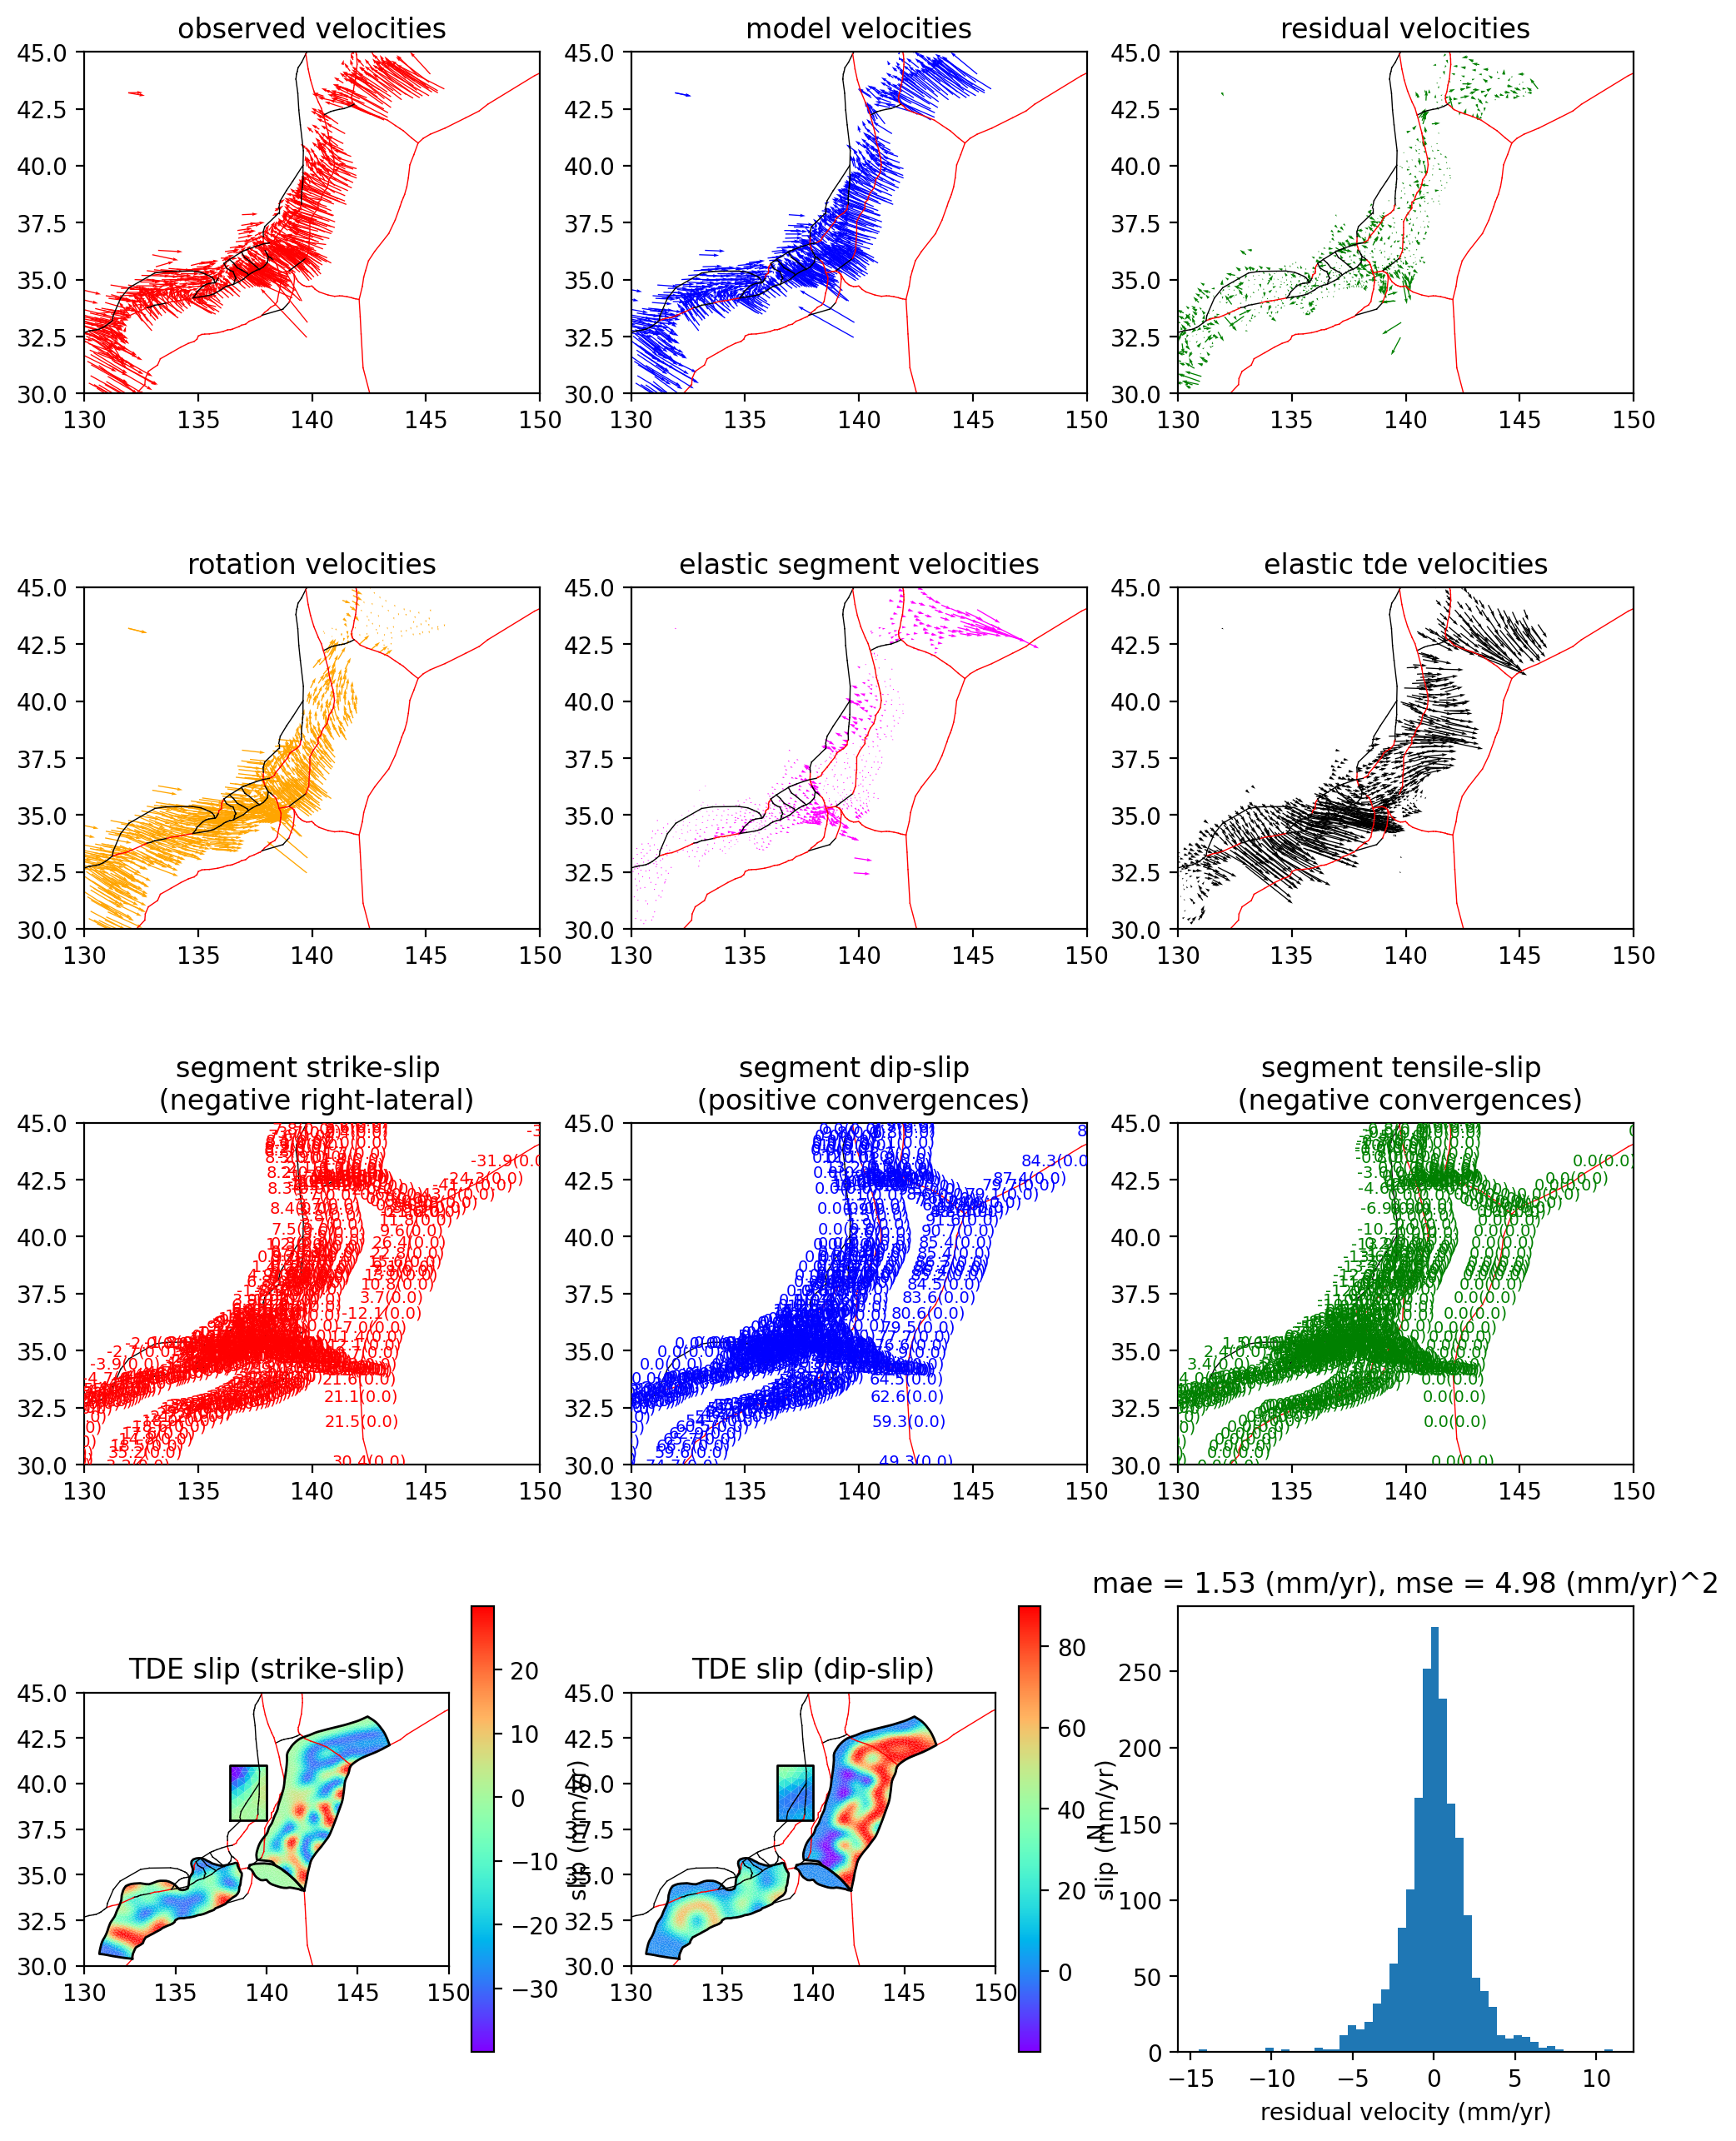

SUCCESS: Wrote figures../runs/0000000504/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6601 - 2024-11-13 18:27:29


<Figure size 640x480 with 0 Axes>

In [6]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

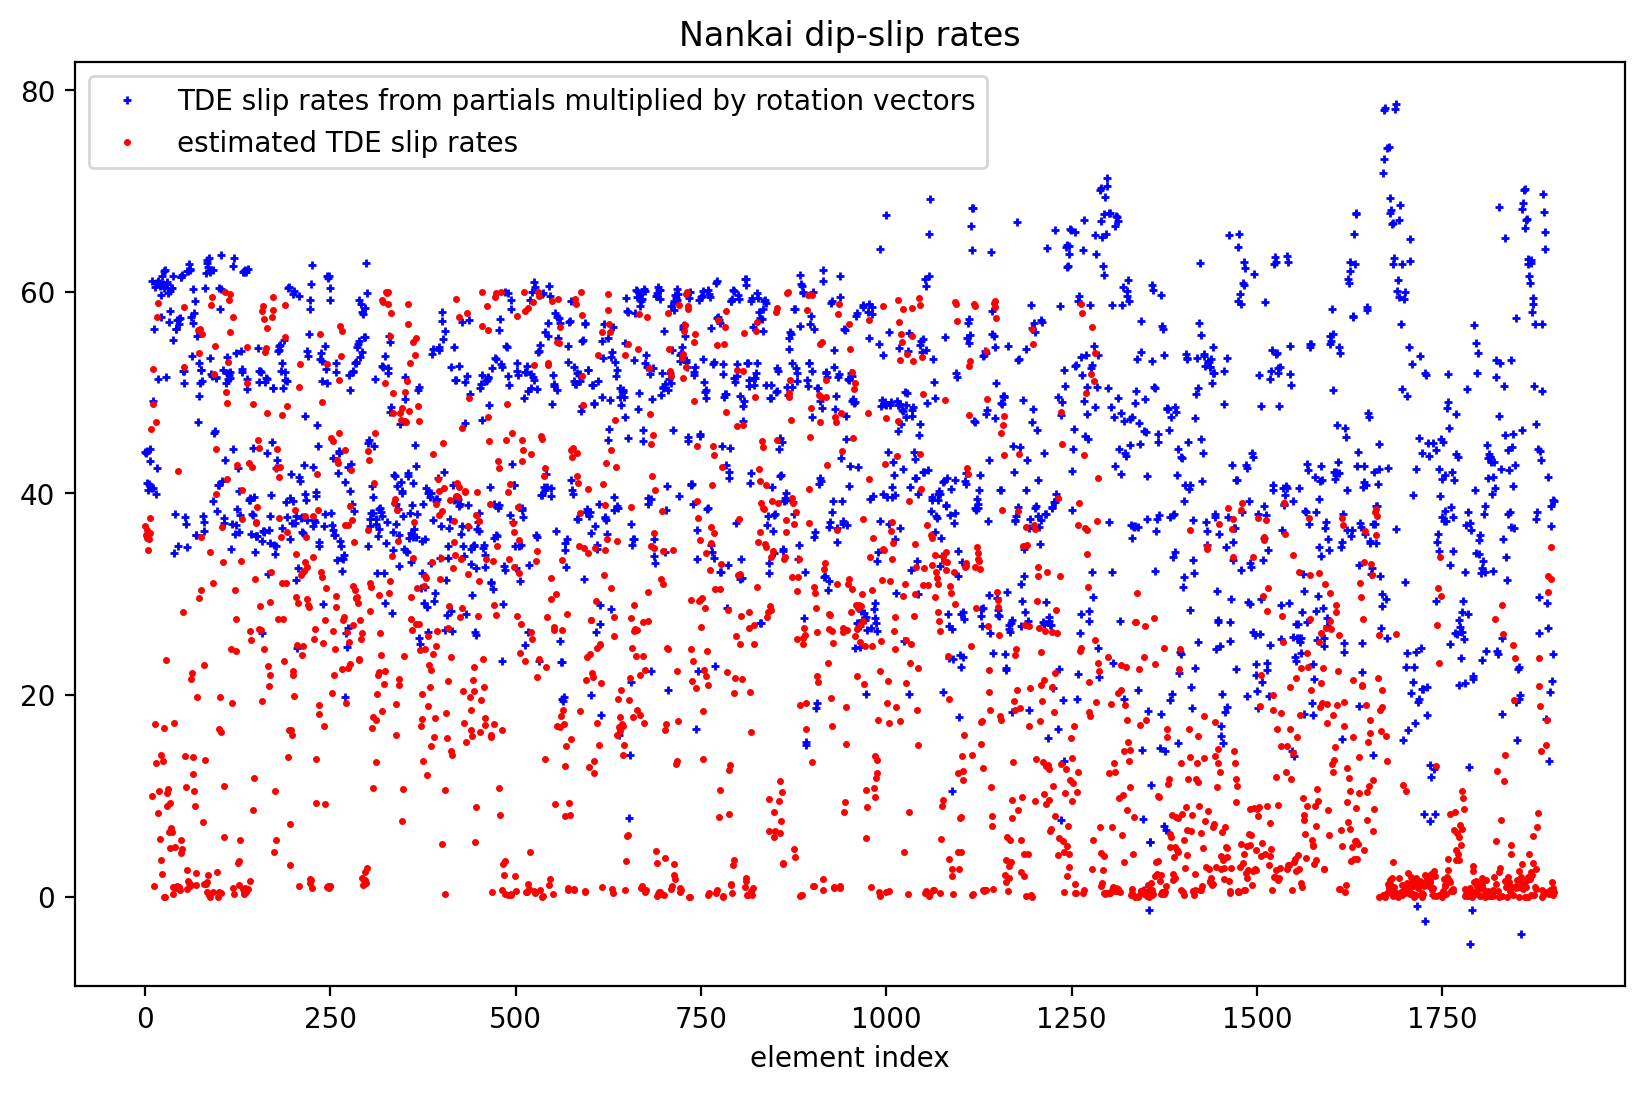

Text(0.5, 1.0, 'strike-slip (elastic)')

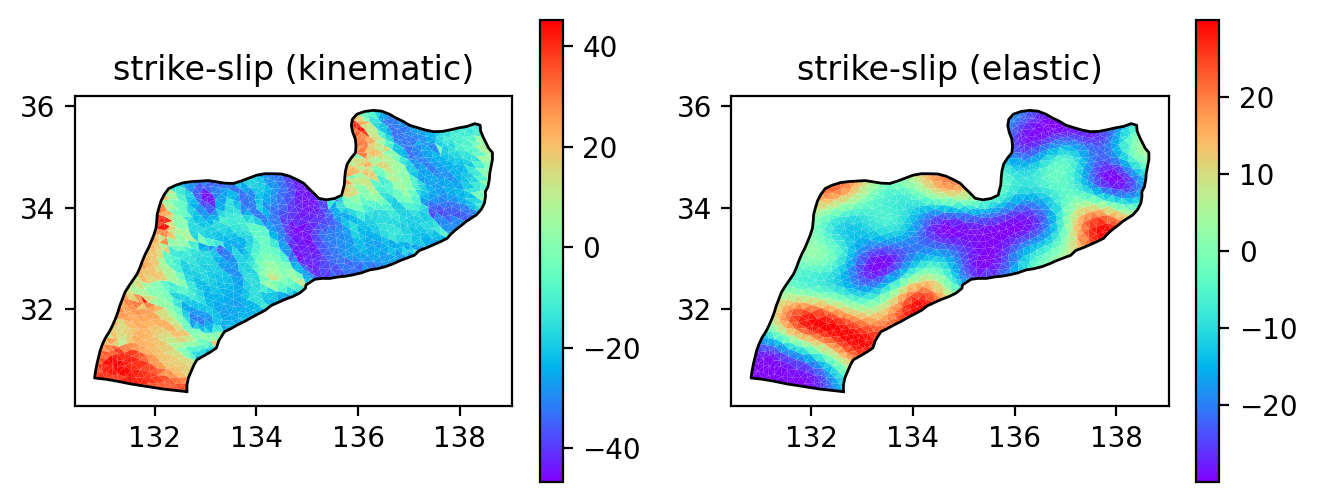

In [7]:
len(estimation_qp.state_vector)

# Multiply rotation vector components by TDE slip rate partials
jpl = (
    operators.rotation_to_tri_slip_rate[0]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

# Multiply eigen modes by eigen to TDE matrix

bjm = (
    operators.eigenvectors_to_tde_slip[0]
    @ estimation_qp.state_vector[3 * len(block) : 3 * len(block) + 100]
)


plt.figure(figsize=(10, 6))
plt.plot(
    jpl[1::2],
    "+b",
    markersize=3,
    label="TDE slip rates from partials multiplied by rotation vectors",
)
plt.plot(bjm[1::2], ".r", markersize=3, label="estimated TDE slip rates")
plt.xlabel("element index")
plt.title("Nankai dip-slip rates")
plt.legend()
plt.show()


def plot_mesh(meshes, fill_value, ax):
    x_coords = meshes.points[:, 0]
    y_coords = meshes.points[:, 1]
    vertex_array = np.asarray(meshes.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc)

    # Add mesh edge
    x_edge = x_coords[meshes.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)
    plt.gca().set_aspect("equal")


plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plot_mesh(meshes[0], jpl[0::2], plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 3, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

# Correct coupling calculation

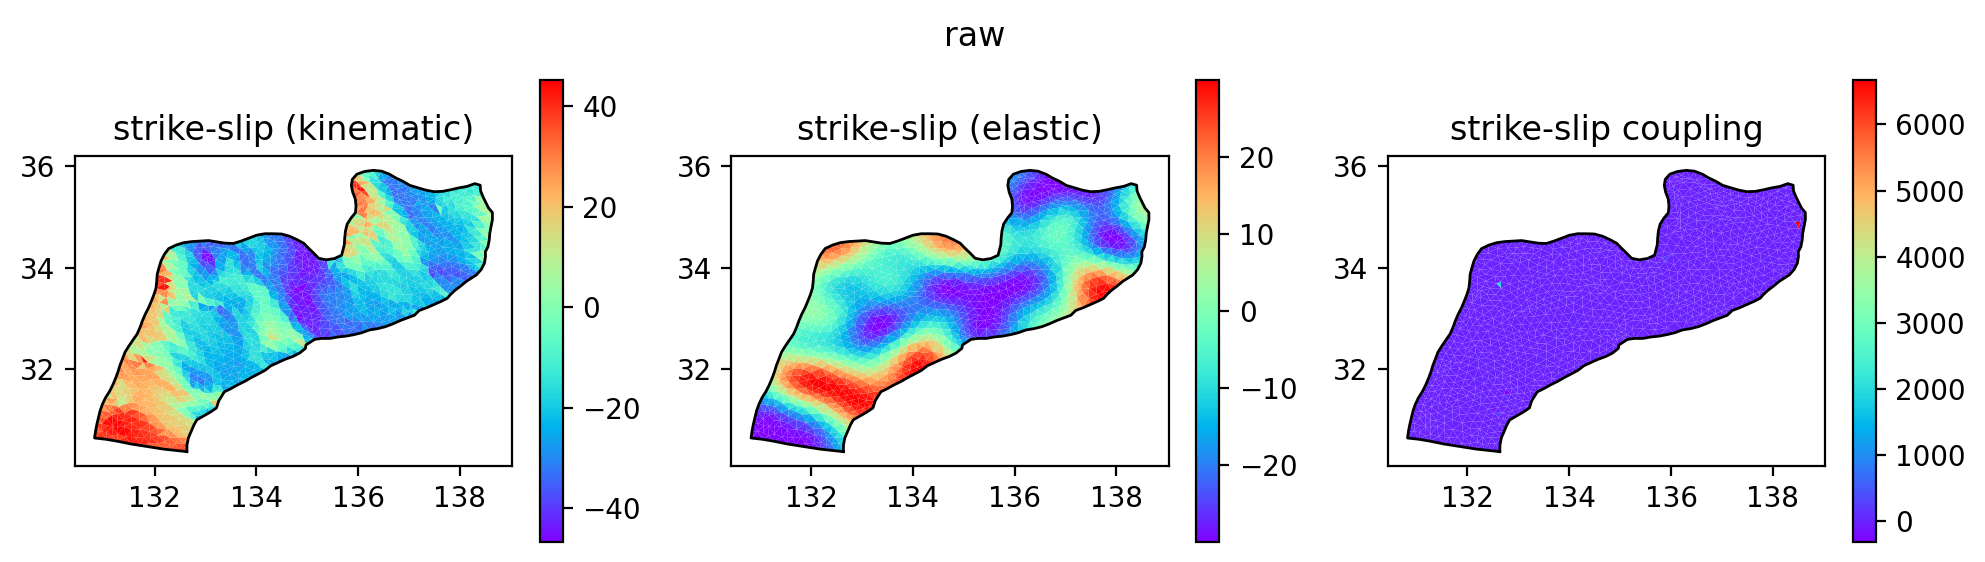

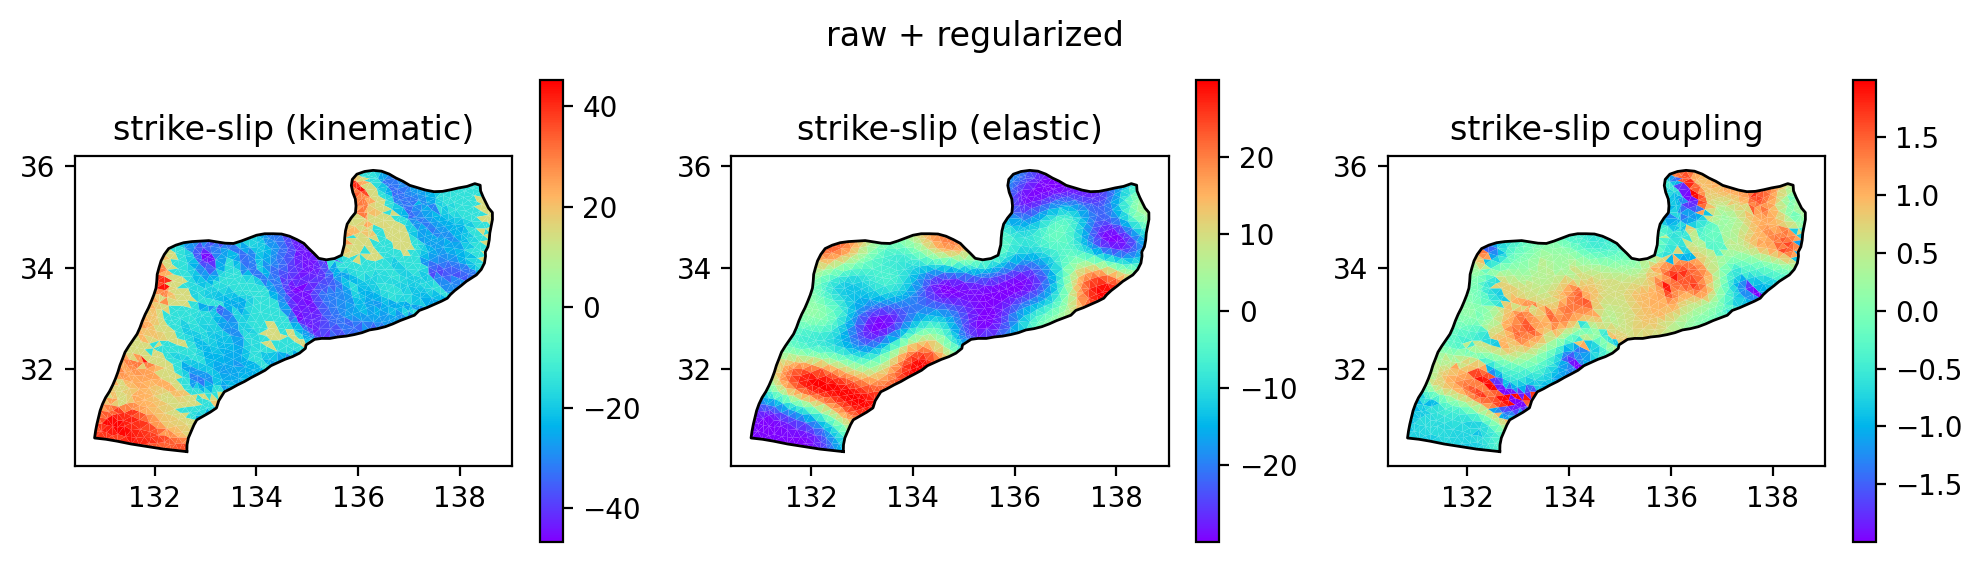

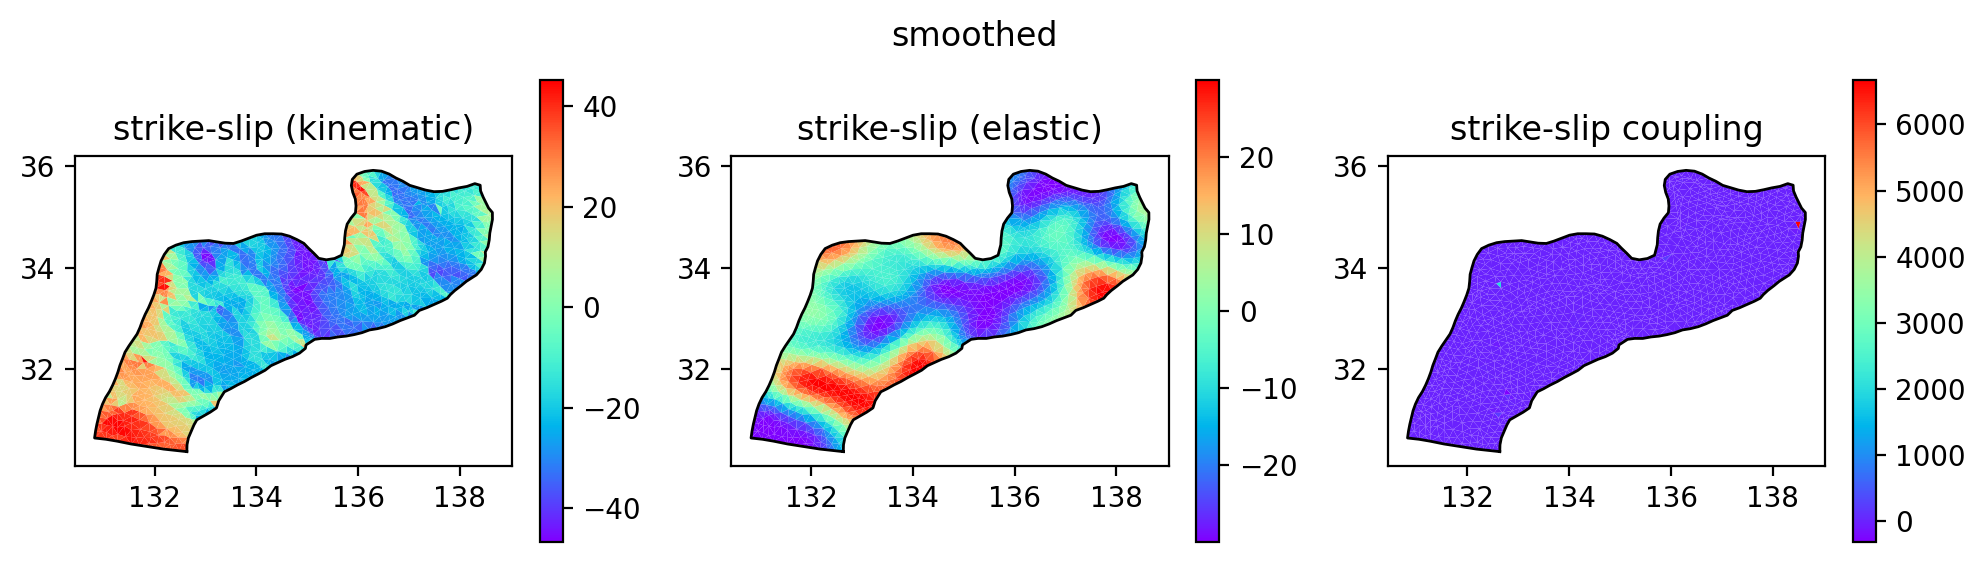

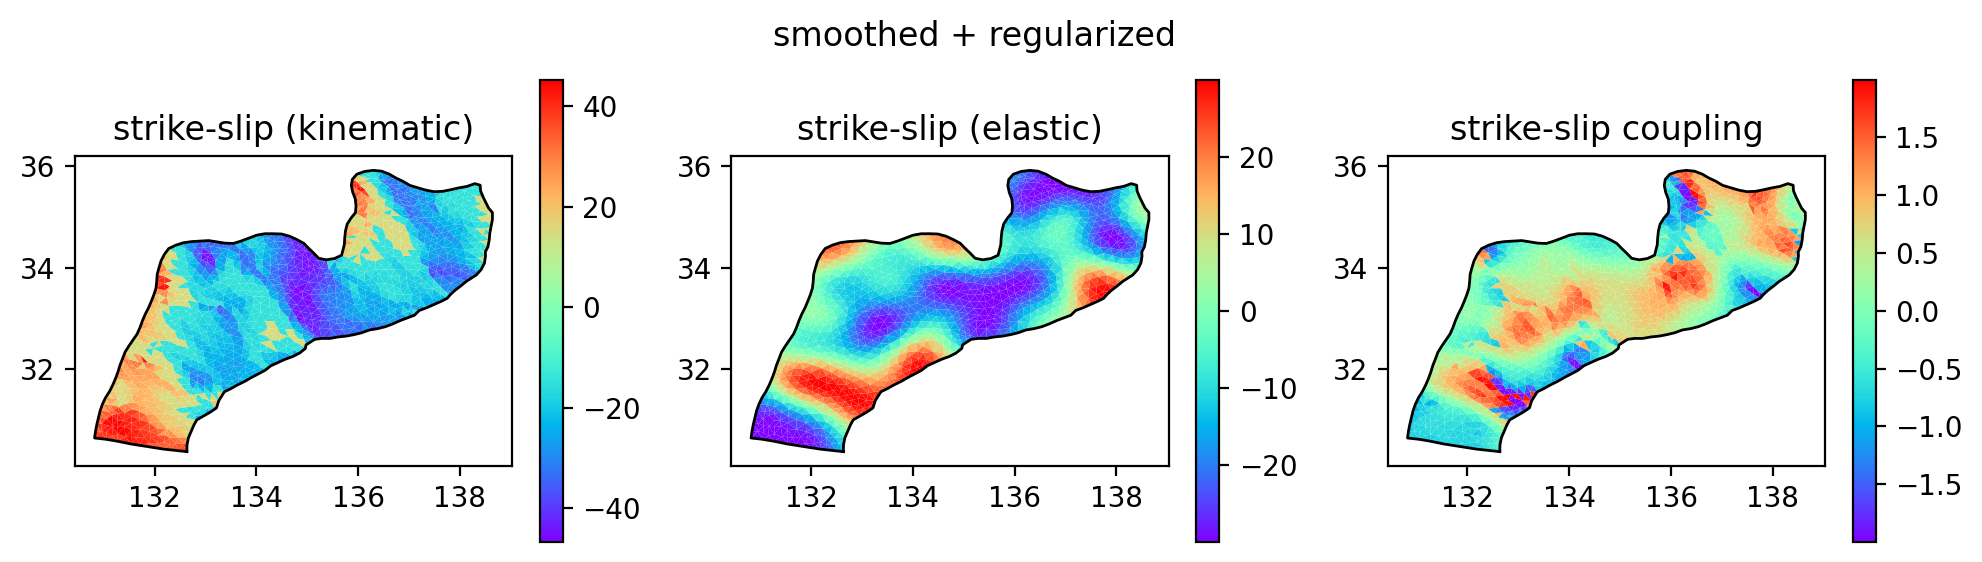

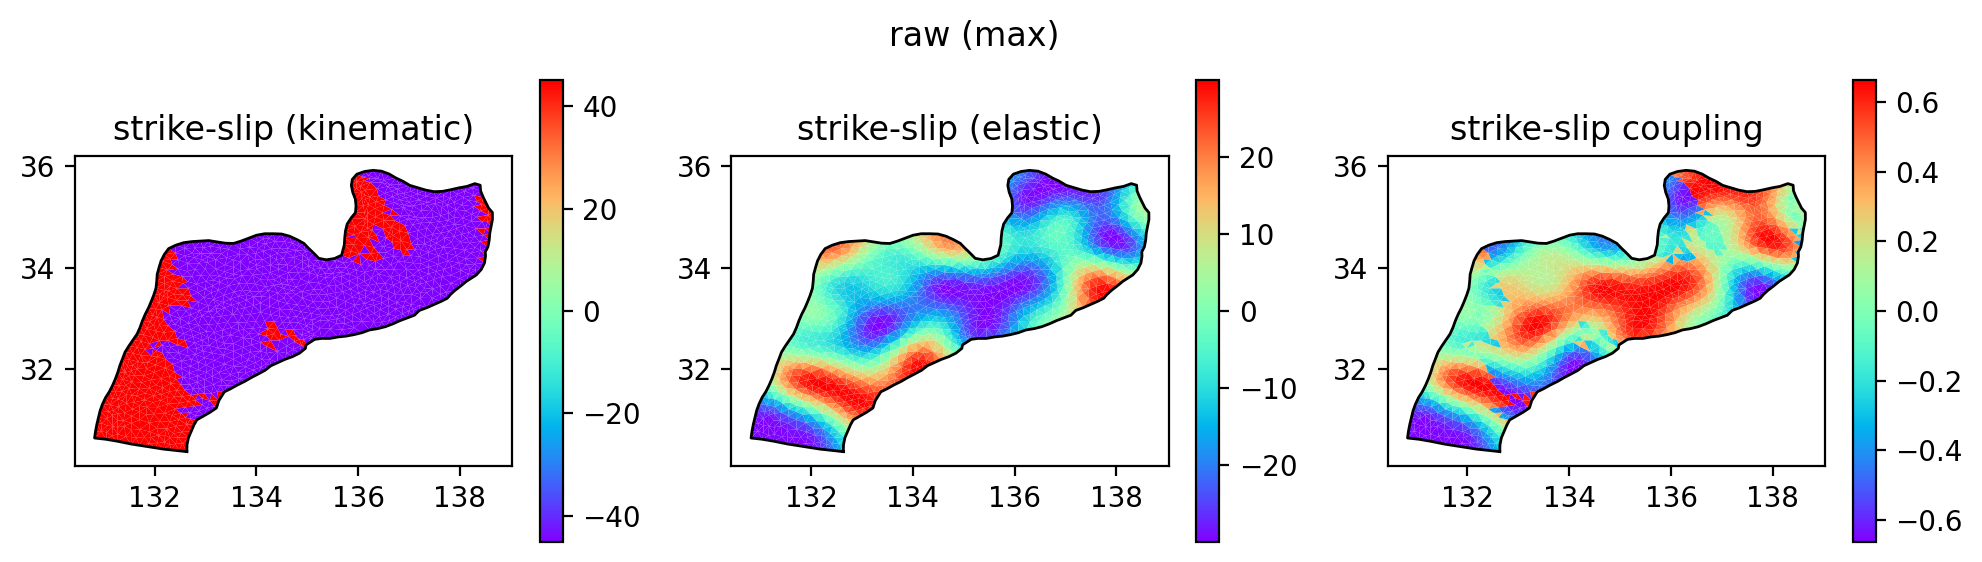

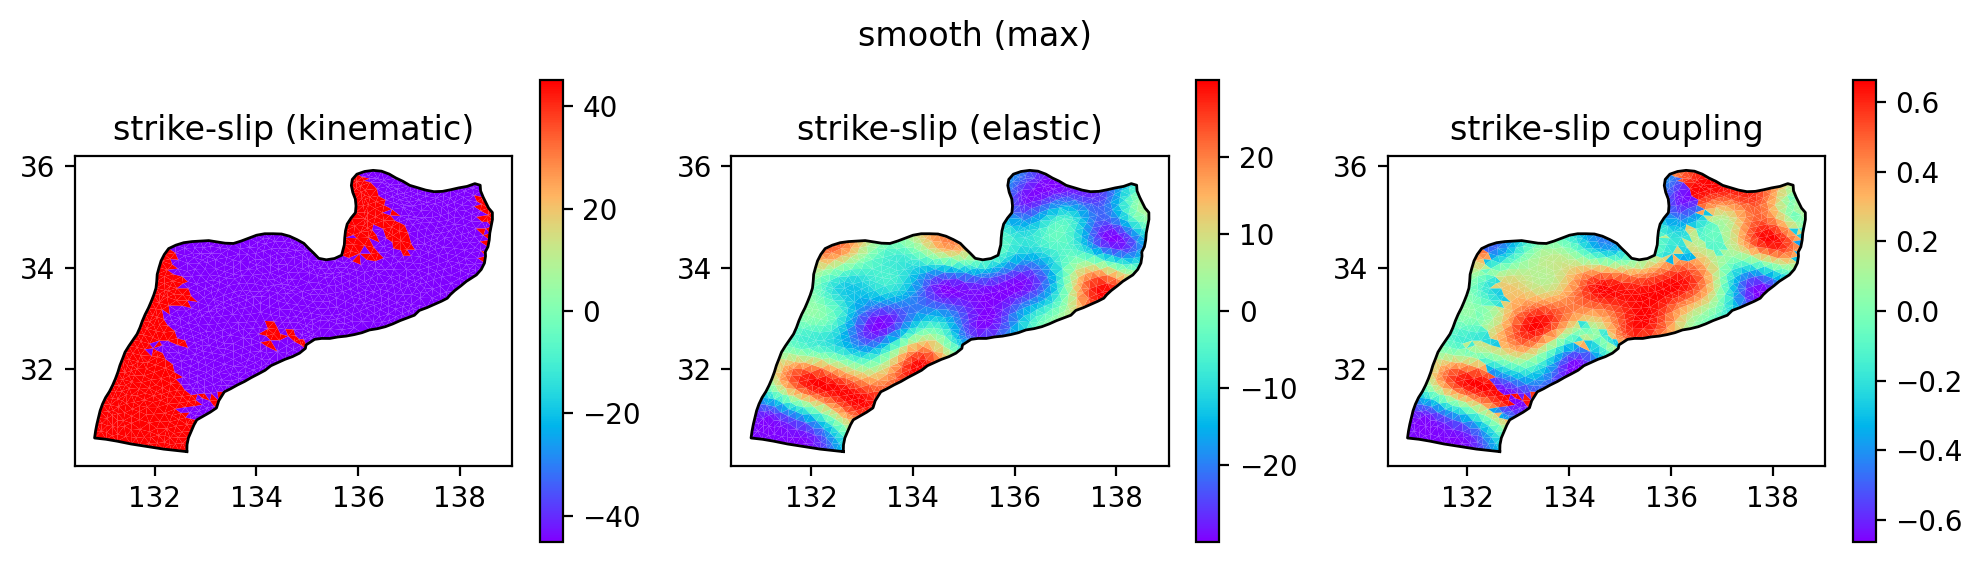

In [8]:
def smooth_irregular_data(x_coords, y_coords, values, length_scale):
    # Build a KDTree for efficient neighbor searching
    points = np.vstack((x_coords, y_coords)).T
    tree = cKDTree(points)

    # Prepare an array to store the smoothed values
    smoothed_values = np.zeros_like(values)

    # Smoothing calculation
    for i, point in enumerate(points):
        # Find neighbors within 3 * length_scale for efficiency
        indices = tree.query_ball_point(point, 3 * length_scale)

        # Calculate distances and apply Gaussian weights
        distances = np.linalg.norm(points[indices] - point, axis=1)
        weights = np.exp(-(distances**2) / (2 * length_scale**2))

        # Weighted sum for smoothing
        smoothed_values[i] = np.sum(weights * values[indices]) / np.sum(weights)

    return smoothed_values


# Smooth kinematic smooth
jpl_ss_smooth = smooth_irregular_data(
    meshes[0].lon_centroid, meshes[0].lat_centroid, jpl[0::2], length_scale=0.01
)

jpl_ds_smooth = smooth_irregular_data(
    meshes[0].lon_centroid, meshes[0].lat_centroid, jpl[1::2], length_scale=0.01
)

coupling_ss = bjm[0::2] / jpl_ss_smooth

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plot_mesh(meshes[0], jpl[0::2], plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 3, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

plt.subplot(1, 3, 3)
plot_mesh(meshes[0], bjm[0::2] / jpl[0::2], plt.gca())
plt.title("strike-slip coupling")
plt.suptitle("raw")
plt.show()


plt.figure(figsize=(12, 3))
a = np.abs(jpl[0::2])
a[a < 15.0] = 15.0
a = a * np.sign(jpl[0::2])

plt.subplot(1, 3, 1)
plot_mesh(meshes[0], a, plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 3, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

plt.subplot(1, 3, 3)
plot_mesh(meshes[0], bjm[0::2] / a, plt.gca())
plt.title("strike-slip coupling")
plt.suptitle("raw + regularized")
plt.show()


plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plot_mesh(meshes[0], jpl_ss_smooth, plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 3, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

plt.subplot(1, 3, 3)
a = np.abs(jpl_ss_smooth)
a = a * np.sign(jpl_ss_smooth)
plot_mesh(meshes[0], bjm[0::2] / a, plt.gca())
plt.title("strike-slip coupling")
plt.suptitle("smoothed")
plt.show()


plt.figure(figsize=(12, 3))
a = np.abs(jpl_ss_smooth)
a[a < 15.0] = 15.0
a = a * np.sign(jpl_ss_smooth)

plt.subplot(1, 3, 1)
plot_mesh(meshes[0], a, plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 3, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

plt.subplot(1, 3, 3)
plot_mesh(meshes[0], bjm[0::2] / a, plt.gca())
plt.title("strike-slip coupling")
plt.suptitle("smoothed + regularized")
plt.show()


plt.figure(figsize=(12, 3))
a = np.max(jpl[0::2])
a = a * np.sign(jpl[0::2])

plt.subplot(1, 3, 1)
plot_mesh(meshes[0], a, plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 3, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

plt.subplot(1, 3, 3)
plot_mesh(meshes[0], bjm[0::2] / a, plt.gca())
plt.title("strike-slip coupling")
plt.suptitle("raw (max)")
plt.show()


plt.figure(figsize=(12, 3))
a = np.max(jpl_ss_smooth)
a = a * np.sign(jpl_ss_smooth)

plt.subplot(1, 3, 1)
plot_mesh(meshes[0], a, plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 3, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

plt.subplot(1, 3, 3)
plot_mesh(meshes[0], bjm[0::2] / a, plt.gca())
plt.title("strike-slip coupling")
plt.suptitle("smooth (max)")
plt.show()

# Iterative approach to finding a solution within coupling bounds

INFO: 
ITERATION 0 - __main__:<module>:295 - 2024-11-13 18:27:31
INFO: SS TDE COUPLING BOUNDS FOR MESH 0, min=-0.5, max=0.5 - __main__:check_coupling_bounds_single_mesh:119 - 2024-11-13 18:27:31
INFO: DS TDE COUPLING BOUNDS FOR MESH 0, min=0, max=1 - __main__:check_coupling_bounds_single_mesh:122 - 2024-11-13 18:27:31
INFO: MIN SS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 396 TDEs - __main__:check_coupling_bounds_single_mesh:150 - 2024-11-13 18:27:31
INFO: MAX SS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 120 TDEs - __main__:check_coupling_bounds_single_mesh:153 - 2024-11-13 18:27:31
INFO: MIN DS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 0 TDEs - __main__:check_coupling_bounds_single_mesh:156 - 2024-11-13 18:27:31
INFO: MAX DS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 0 TDEs - __main__:check_coupling_bounds_single_mesh:159 - 2024-11-13 18:27:31
INFO: TOTAL TDES OOB 516 TDEs - __main__:check_coupling_bounds_single_mesh:162 - 2024-11-13 18:27:31
INFO: CONTINUE COUPLING RELAXATION ITERATION: True - __

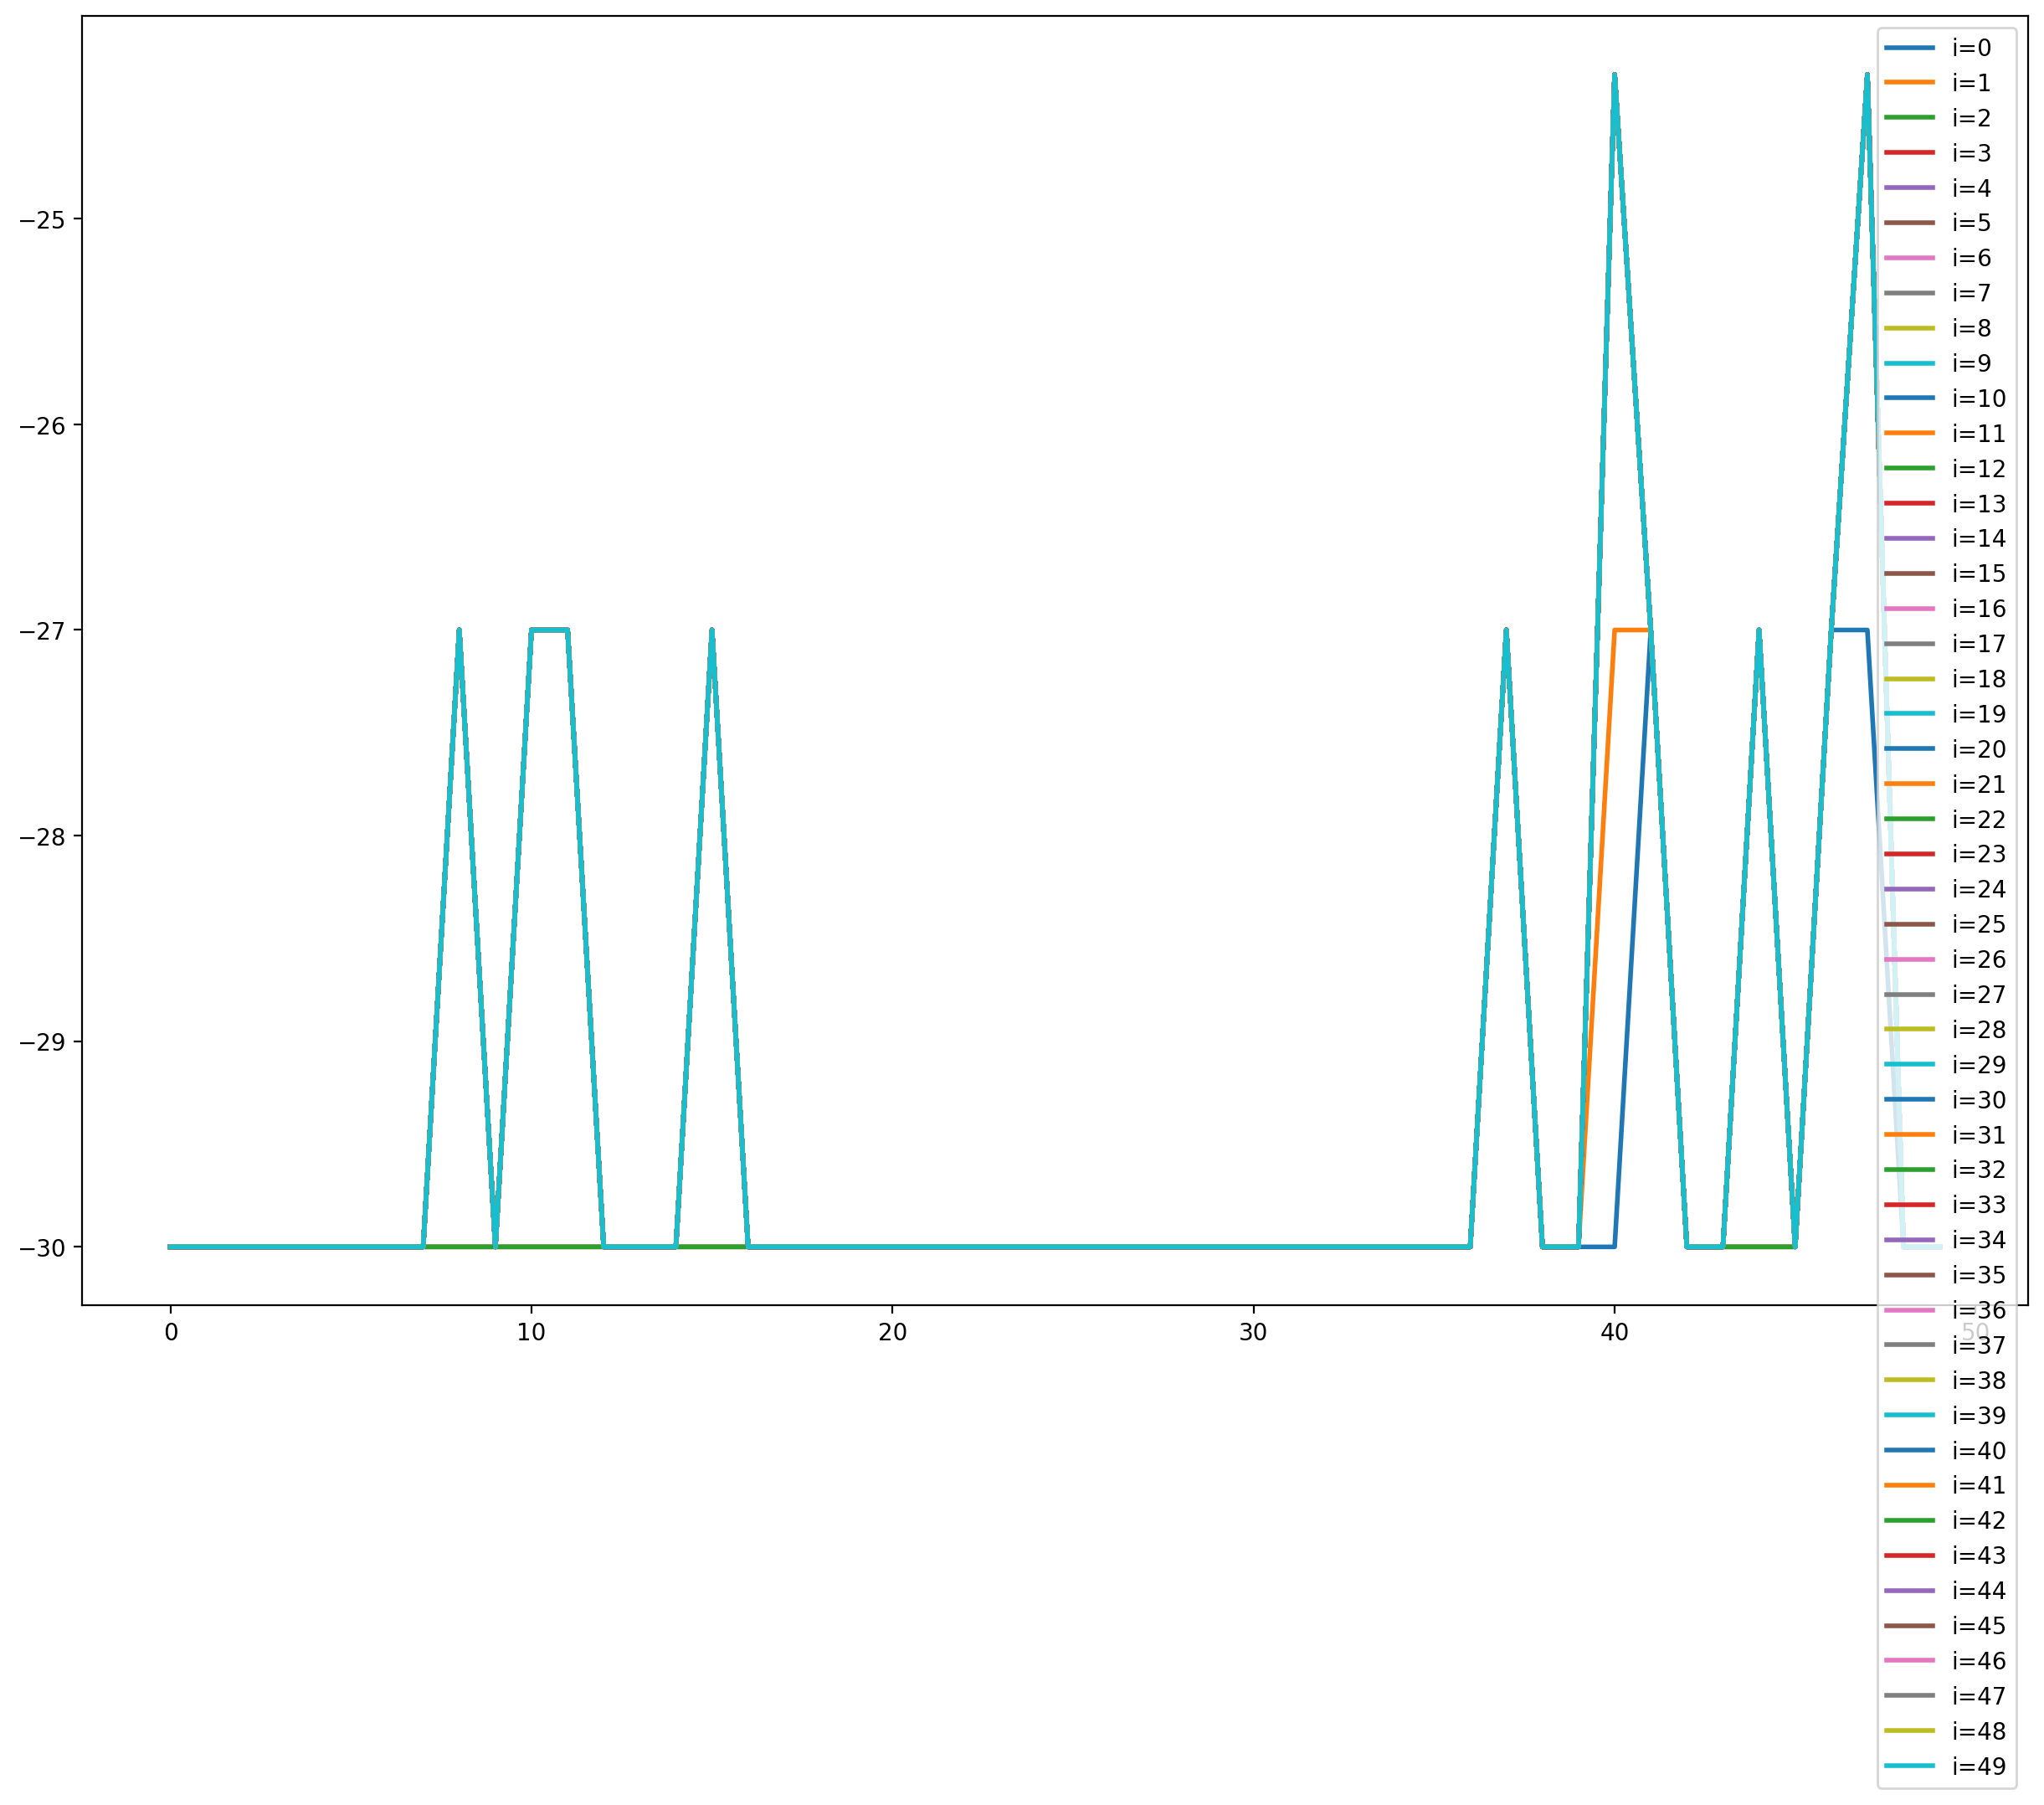

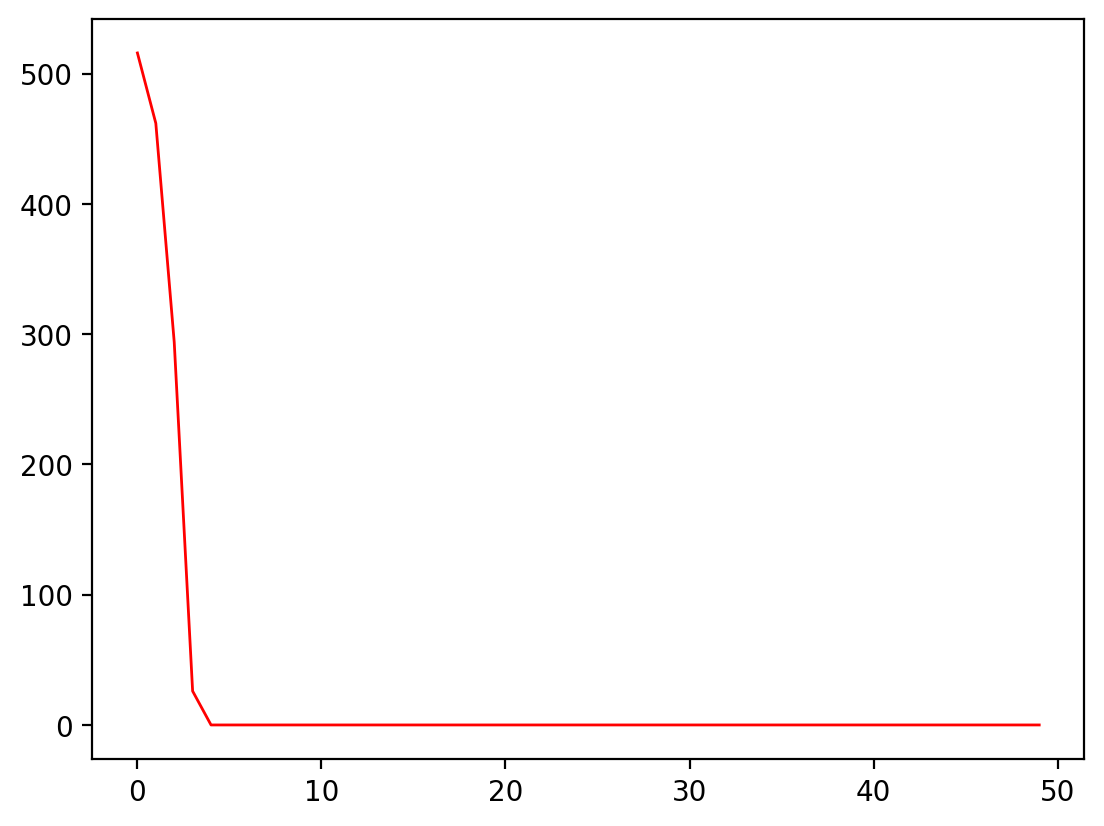

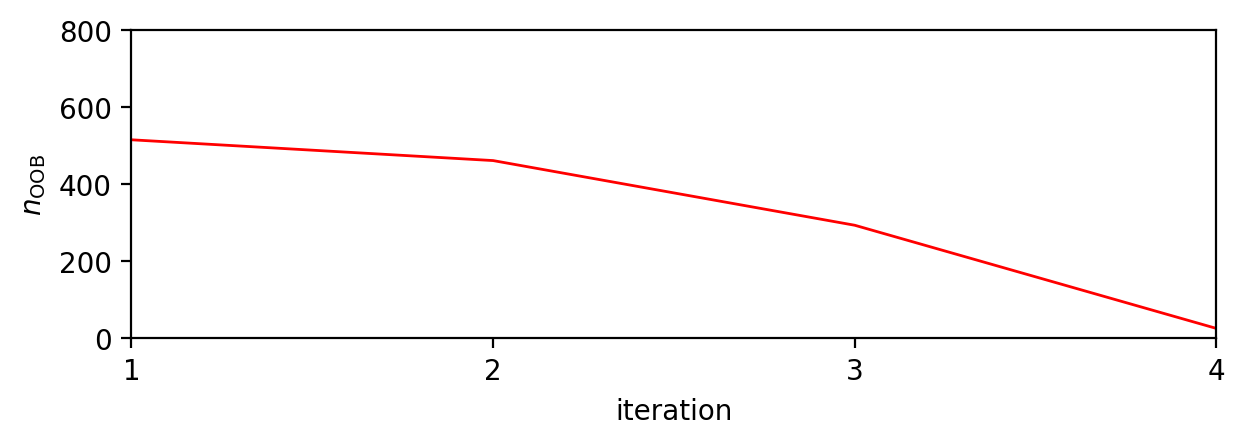

In [9]:
def check_coupling_bounds_single_mesh(
    meshes,
    mesh_idx,
    estimation_qp,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
    debug_plot=False,
):
    """
    *mesh_parameter.json variable names for reference:

    TDE rate bounds:
    "qp_mesh_tde_bound": 1,
    "qp_mesh_tde_slip_rate_lower_bound_ss": -30,
    "qp_mesh_tde_slip_rate_upper_bound_ss": 30,
    "qp_mesh_tde_slip_rate_lower_bound_ds": 0,
    "qp_mesh_tde_slip_rate_upper_bound_ds": 60,

    TDE coupling bounds:
    "qp_mesh_tde_bound_coupling": 0,
    "qp_mesh_tde_slip_rate_lower_bound_ss_coupling": -0.5,
    "qp_mesh_tde_slip_rate_upper_bound_ss_coupling": 0.5,
    "qp_mesh_tde_slip_rate_lower_bound_ds_coupling": 0,
    "qp_mesh_tde_slip_rate_upper_bound_ds_coupling": 1,

    """

    # for i in range(np.max(segment.patch_file_name) + 1):
    # for i in range(1):
    # Calculate coupling for each non-CMI mesh

    # Multiply rotation vector components by TDE slip rate partials
    kinematic_tde_rates = (
        operators.rotation_to_tri_slip_rate[mesh_idx]
        @ estimation_qp.state_vector[0 : 3 * len(block)]
    )

    # Multiply eigen modes by eigen to TDE matrix
    estimated_tde_rates = (
        operators.eigenvectors_to_tde_slip[mesh_idx]
        @ estimation_qp.state_vector[
            3 * len(block) : 3 * len(block)
            + (meshes[mesh_idx].n_modes_strike_slip + meshes[mesh_idx].n_modes_dip_slip)
        ]  # TODO: Fix column indexing
    )

    #
    # Calculate coupling
    # - smoothed kinematic
    # - lower threshold for kinematic
    # TODO: Do I need a sign check?
    #

    # Smooth kinematic smooth
    kinematic_tde_rates_ss_smooth = smooth_irregular_data(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        kinematic_tde_rates[0::2],
        length_scale=0.01,
    )
    kinematic_tde_rates_ds_smooth = smooth_irregular_data(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        kinematic_tde_rates[1::2],
        length_scale=0.01,
    )

    # Regularize kinematic rates
    REGULARIZATION_RATE = 20.0
    negative_regularization_idx_ss = np.where(
        (kinematic_tde_rates_ss_smooth > -REGULARIZATION_RATE)
        & (kinematic_tde_rates_ss_smooth < 0)
    )
    kinematic_tde_rates_ss_smooth[negative_regularization_idx_ss] = REGULARIZATION_RATE

    positive_regularization_idx_ss = np.where(
        (kinematic_tde_rates_ss_smooth < REGULARIZATION_RATE)
        & (kinematic_tde_rates_ss_smooth > 0)
    )
    kinematic_tde_rates_ss_smooth[positive_regularization_idx_ss] = REGULARIZATION_RATE

    negative_regularization_idx_ds = np.where(
        (kinematic_tde_rates_ds_smooth > -REGULARIZATION_RATE)
        & (kinematic_tde_rates_ds_smooth < 0)
    )
    kinematic_tde_rates_ds_smooth[negative_regularization_idx_ds] = REGULARIZATION_RATE

    positive_regularization_idx_ds = np.where(
        (kinematic_tde_rates_ds_smooth < REGULARIZATION_RATE)
        & (kinematic_tde_rates_ds_smooth > 0)
    )
    kinematic_tde_rates_ds_smooth[positive_regularization_idx_ds] = REGULARIZATION_RATE

    tde_coupling_ss = estimated_tde_rates[0::2] / kinematic_tde_rates_ss_smooth
    tde_coupling_ds = estimated_tde_rates[1::2] / kinematic_tde_rates_ds_smooth

    #
    # Calculate coupling
    # - max kinematic slip rate version
    # TODO: Do I need a sign check?
    #
    tde_coupling_ss = estimated_tde_rates[0::2] / np.max(
        np.abs(kinematic_tde_rates[0::2])
    )
    tde_coupling_ds = estimated_tde_rates[1::2] / np.max(
        np.abs(kinematic_tde_rates[1::2])
    )

    # tde_coupling_ss = estimated_tde_rates[0::2] / (
    #     40 * np.sign(kinematic_tde_rates[0::2])
    # )
    # tde_coupling_ds = estimated_tde_rates[1::2] / (
    #     40 * np.sign(kinematic_tde_rates[1::2])
    # )

    # Report on OOB cases
    logger.info(
        f"SS TDE COUPLING BOUNDS FOR MESH {mesh_idx}, min={meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling}, max={meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling}"
    )
    logger.info(
        f"DS TDE COUPLING BOUNDS FOR MESH {mesh_idx}, min={meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling}, max={meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling}"
    )

    # Find indices of TDEs with out of bound coupling values
    tde_coupling_ss_lower_oob_idx = np.where(
        tde_coupling_ss < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
    )[0]
    tde_coupling_ss_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )[0]

    tde_coupling_ds_lower_oob_idx = np.where(
        tde_coupling_ds < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
    )[0]
    tde_coupling_ds_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )[0]

    # Total number of OOB coupling constraints
    n_oob = (
        len(tde_coupling_ss_lower_oob_idx)
        + len(tde_coupling_ss_upper_oob_idx)
        + len(tde_coupling_ds_lower_oob_idx)
        + len(tde_coupling_ds_upper_oob_idx)
    )

    # Report the number and type of coupling OOB
    logger.info(
        f"MIN SS TDE COUPLING BOUNDS FOR MESH {i}, OOB AT {len(tde_coupling_ss_lower_oob_idx)} TDEs"
    )
    logger.info(
        f"MAX SS TDE COUPLING BOUNDS FOR MESH {i}, OOB AT {len(tde_coupling_ss_upper_oob_idx)} TDEs"
    )
    logger.info(
        f"MIN DS TDE COUPLING BOUNDS FOR MESH {i}, OOB AT {len(tde_coupling_ds_lower_oob_idx)} TDEs"
    )
    logger.info(
        f"MAX DS TDE COUPLING BOUNDS FOR MESH {i}, OOB AT {len(tde_coupling_ds_upper_oob_idx)} TDEs"
    )
    logger.info(f"TOTAL TDES OOB {n_oob} TDEs")

    # Determine whether or not updating is required
    if n_oob > 0:
        continue_iterate_for_coupling_bounds = True
    else:
        continue_iterate_for_coupling_bounds = False
    logger.info(
        f"CONTINUE COUPLING RELAXATION ITERATION: {continue_iterate_for_coupling_bounds}"
    )

    # Make vectors for update slip rates (not neccesary but useful for debugging)
    updated_ss_bounds_lower = np.copy(current_ss_bounds_lower)
    updated_ss_bounds_upper = np.copy(current_ss_bounds_upper)
    updated_ds_bounds_lower = np.copy(current_ds_bounds_lower)
    updated_ds_bounds_upper = np.copy(current_ds_bounds_upper)

    # Update slip rate bounds
    SLIP_RATE_REDUCTION_FACTOR = 0.9
    updated_ss_bounds_lower[tde_coupling_ss_lower_oob_idx] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ss_bounds_upper[tde_coupling_ss_upper_oob_idx] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ds_bounds_lower[tde_coupling_ds_lower_oob_idx] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ds_bounds_upper[tde_coupling_ds_upper_oob_idx] *= SLIP_RATE_REDUCTION_FACTOR

    # updated_ss_bounds_lower[tde_coupling_ss_lower_oob_idx] += 1.0
    # updated_ss_bounds_upper[tde_coupling_ss_upper_oob_idx] += -1.0
    # updated_ds_bounds_lower[tde_coupling_ds_lower_oob_idx] += 1.0
    # updated_ds_bounds_upper[tde_coupling_ds_upper_oob_idx] += -1.0

    if debug_plot == True:
        # Plot locations of TDEs with out of bound coupling values
        plt.figure(figsize=(11, 5))
        plt.subplot(1, 2, 1)
        plot_mesh(meshes[mesh_idx], tde_coupling_ss, plt.gca())
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ss_lower_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ss_lower_oob_idx],
            "k+",
            label="below min",
        )
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ss_upper_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ss_upper_oob_idx],
            "g+",
            label="above max",
        )
        plt.legend()
        plt.title("strike-slip coupling oob")

        plt.subplot(1, 2, 2)
        plot_mesh(meshes[mesh_idx], tde_coupling_ds, plt.gca())
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ds_lower_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ds_lower_oob_idx],
            "bx",
            label="below min",
        )
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ds_upper_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ds_upper_oob_idx],
            "g+",
            label="above max",
        )
        plt.legend()
        plt.title("dip-slip coupling oob")
        plt.show()

        # Plot adjusted bounds on mesh
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plot_mesh(meshes[mesh_idx], updated_ss_bounds_lower, plt.gca())
        plt.title("ss adjusted lower bounds")
        plt.subplot(1, 4, 2)
        plot_mesh(meshes[mesh_idx], updated_ss_bounds_upper, plt.gca())
        plt.title("ss adjusted upper bounds")
        plt.subplot(1, 4, 3)
        plot_mesh(meshes[mesh_idx], updated_ds_bounds_lower, plt.gca())
        plt.title("ds adjusted lower bounds")
        plt.subplot(1, 4, 4)
        plot_mesh(meshes[mesh_idx], updated_ds_bounds_upper, plt.gca())
        plt.title("ds adjusted upper bounds")
        plt.show()

    return (
        continue_iterate_for_coupling_bounds,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
        n_oob,
    )


# Get total number of segment meshes
command.n_segment_meshes = np.max(segment.patch_file_name)

# Get intial ("current") TDE slip rates for each segment mesh
current_ss_bounds_lower = [np.array([])] * command.n_segment_meshes
current_ss_bounds_upper = [np.array([])] * command.n_segment_meshes
current_ds_bounds_lower = [np.array([])] * command.n_segment_meshes
current_ds_bounds_upper = [np.array([])] * command.n_segment_meshes

for i in range(command.n_segment_meshes):
    current_ss_bounds_lower[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(meshes[i].n_tde)
    current_ss_bounds_upper[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(meshes[i].n_tde)
    current_ds_bounds_lower[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(meshes[i].n_tde)
    current_ds_bounds_upper[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(meshes[i].n_tde)


# Start relaxation iterations

plt.figure(figsize=(15, 10))

n_iter = 50
n_oob_vec = np.zeros(n_iter)
store_ss_lower = np.zeros((meshes[0].n_tde, n_iter))
store_ss_upper = np.zeros((meshes[0].n_tde, n_iter))
store_ds_lower = np.zeros((meshes[0].n_tde, n_iter))
store_ds_upper = np.zeros((meshes[0].n_tde, n_iter))

for i in range(n_iter):

    # Loop over meshes

    # Check bounds
    logger.info(f"\nITERATION {i}")
    (
        continue_iterate_for_coupling_bounds,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
        n_oob,
    ) = check_coupling_bounds_single_mesh(
        meshes,
        0,  # This is the mesh index
        estimation_qp,
        current_ss_bounds_lower[0],
        current_ss_bounds_upper[0],
        current_ds_bounds_lower[0],
        current_ds_bounds_upper[0],
        debug_plot=False,
    )
    logger.info(f"{n_oob} TDEs with out of coupling bounds")

    # Store total number of OOB elements at this iteration step
    n_oob_vec[i] = n_oob

    # Build and insert update slip rate bounds into QP inequality vector
    updated_lower_bounds = -1.0 * celeri.interleave2(
        updated_ss_bounds_lower, updated_ds_bounds_lower
    )
    updated_upper_bounds = celeri.interleave2(
        updated_ss_bounds_upper, updated_ds_bounds_upper
    )
    updated_bounds = np.hstack((updated_lower_bounds, updated_upper_bounds))

    updated_qp_inequality_constraints_data_vector = np.copy(
        qp_inequality_constraints_data_vector
    )

    updated_qp_inequality_constraints_data_vector[0 : len(updated_bounds)] = (
        updated_bounds
    )

    # QP solve with updated TDE slip rate constraints
    solution_qp = celeri.lsqlin_qp(
        operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
        data_vector_eigen * np.sqrt(weighting_vector_eigen),
        0,
        qp_inequality_constraints_matrix,  # Inequality matrix
        updated_qp_inequality_constraints_data_vector,  # Inequality data vector
        None,
        None,
        None,
        None,
        None,
        {"show_progress": False},
    )

    # Create estimation data structure and calculate derived quantities
    estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
    estimation_qp.operator = operators.eigen
    celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)

    # Set *updated* to *current* for next iteration
    current_ss_bounds_lower[0] = np.copy(updated_ss_bounds_lower)
    current_ss_bounds_upper[0] = np.copy(updated_ss_bounds_upper)
    current_ds_bounds_lower[0] = np.copy(updated_ds_bounds_lower)
    current_ds_bounds_upper[0] = np.copy(updated_ds_bounds_upper)

    store_ss_lower[:, i] = current_ss_bounds_lower[0]
    store_ss_upper[:, i] = current_ss_bounds_upper[0]
    store_ds_lower[:, i] = current_ds_bounds_lower[0]
    store_ds_upper[:, i] = current_ds_bounds_upper[0]

    plt.plot(current_ss_bounds_lower[0][0:50], linewidth=2.0, label=f"{i=}")

plt.legend()
plt.show()

# Plot convergence

plt.figure()
plt.plot(n_oob_vec, "-r", linewidth=1.0)
plt.show()

first_min_index = np.where(n_oob_vec == np.min(n_oob_vec))[0][0]
plt.figure(figsize=(7, 2))
xx = np.arange(1, first_min_index + 1)
plt.plot(xx, n_oob_vec[0:first_min_index], "-r", linewidth=1.0)
plt.xlabel("iteration")
plt.ylabel("$n_\mathrm{OOB}$")
plt.xticks(xx)
plt.xlim([np.min(xx), np.max(xx)])
plt.ylim([0, 800])
plt.show()

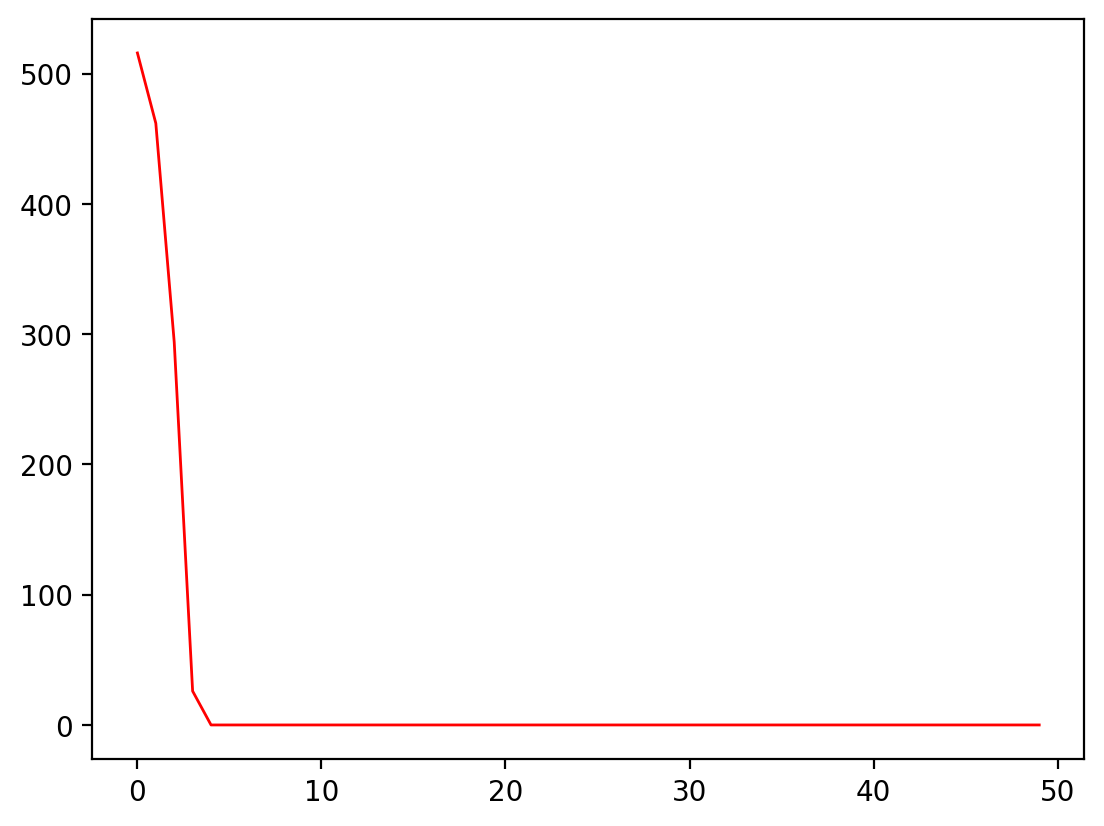

In [10]:
plt.plot(n_oob_vec, "-r", linewidth=1.0)

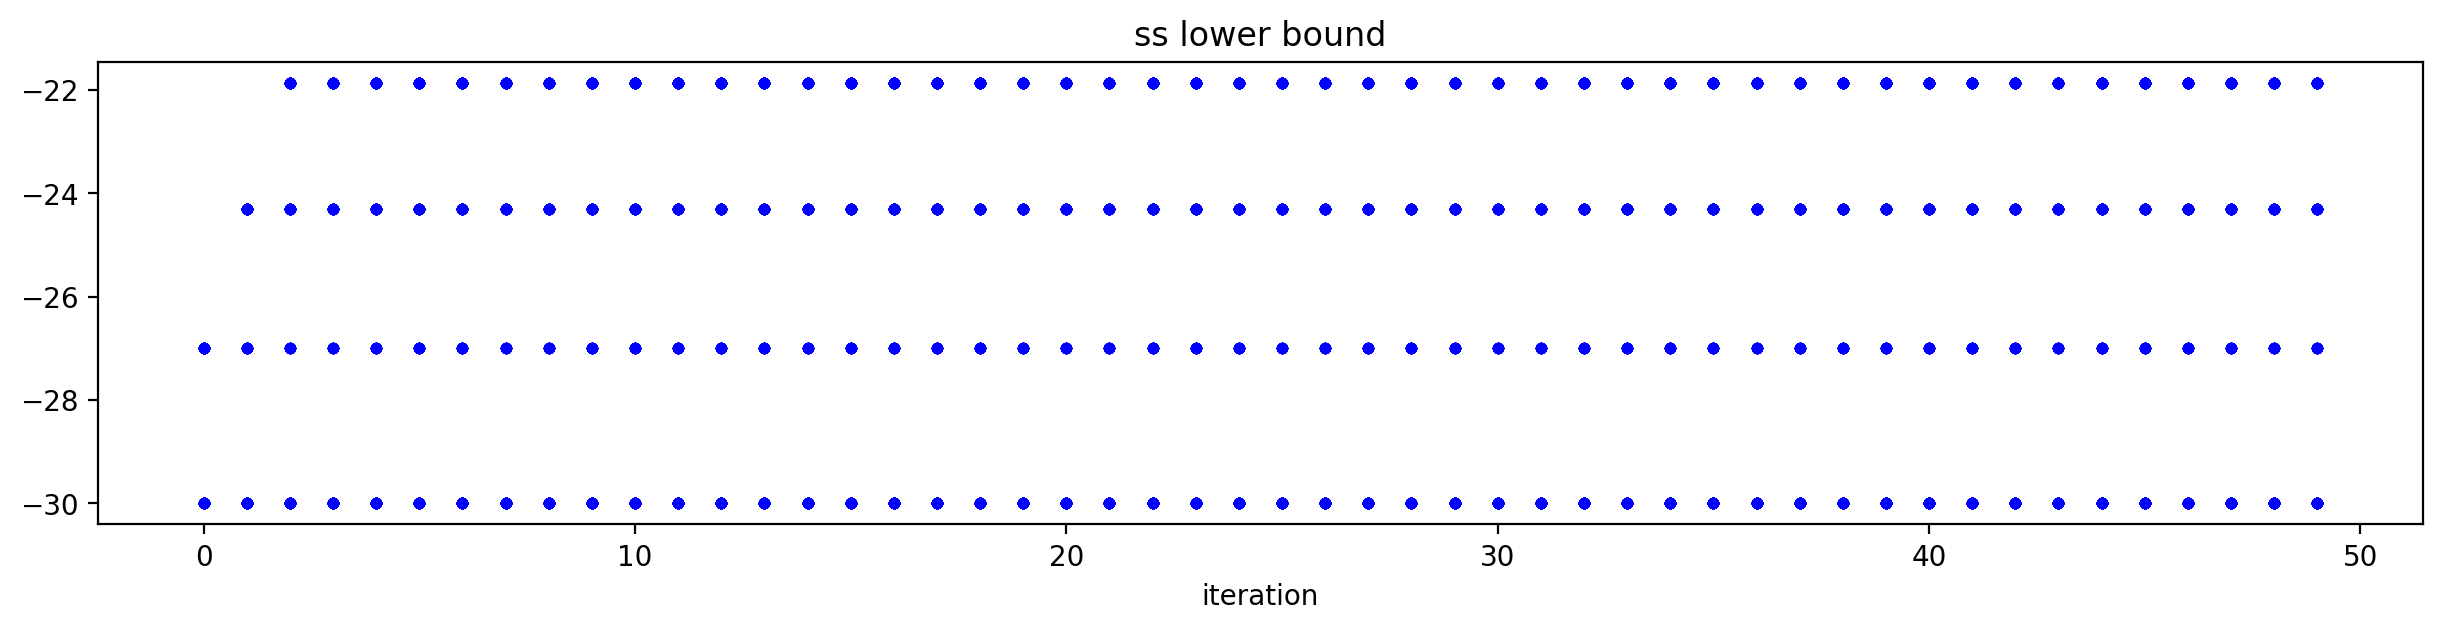

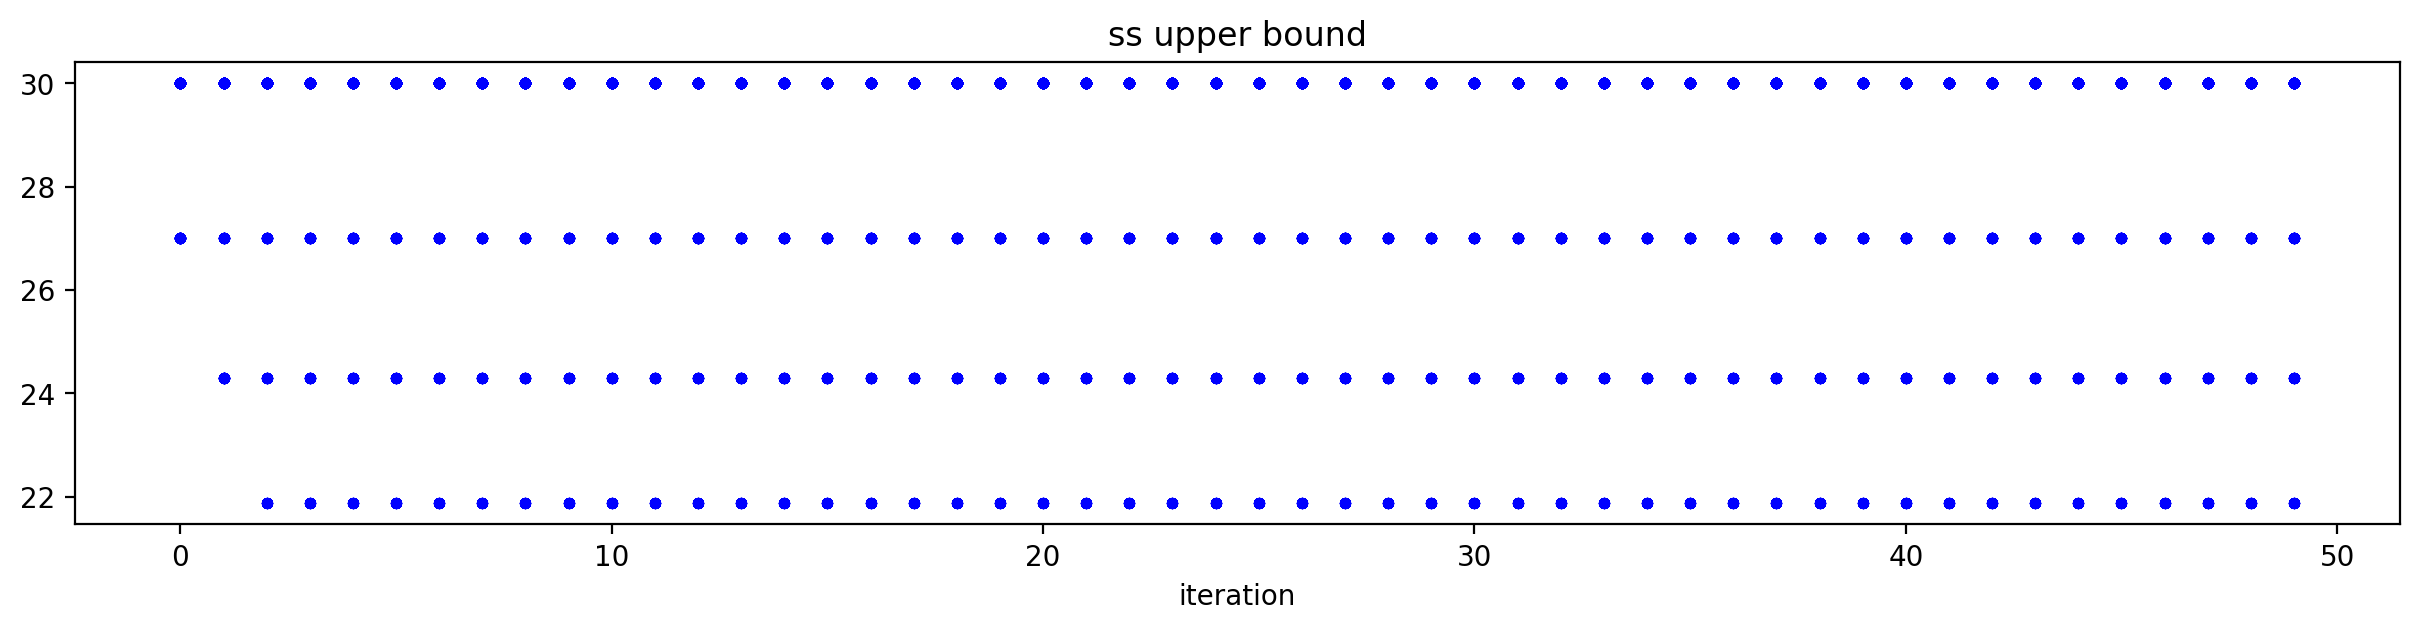

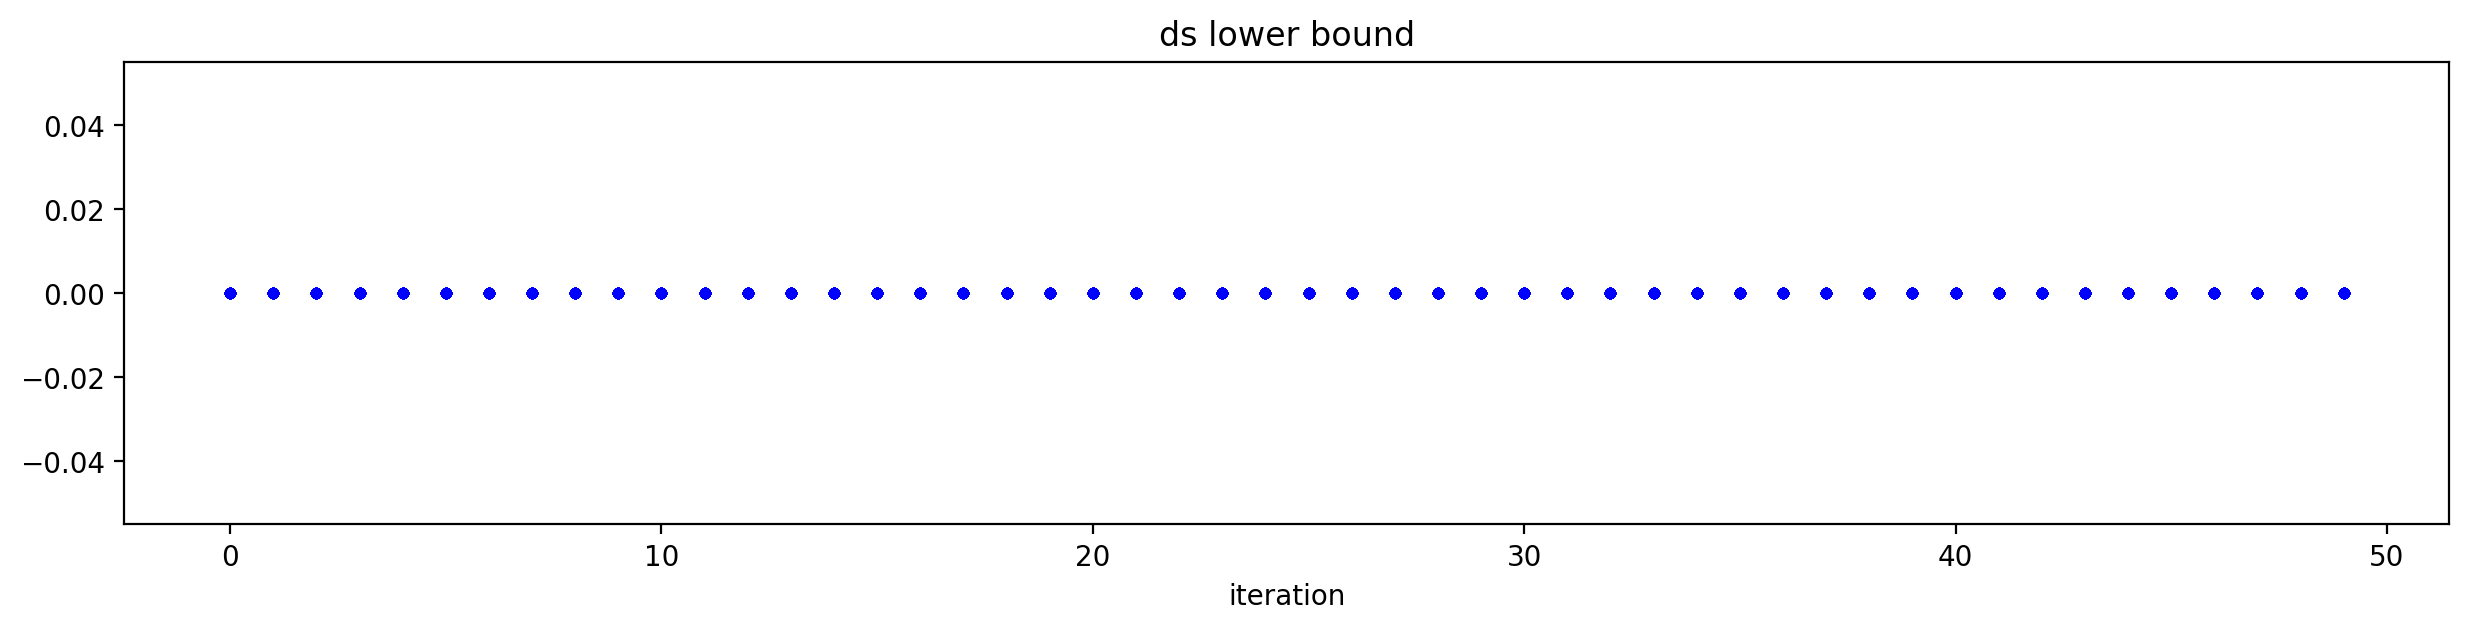

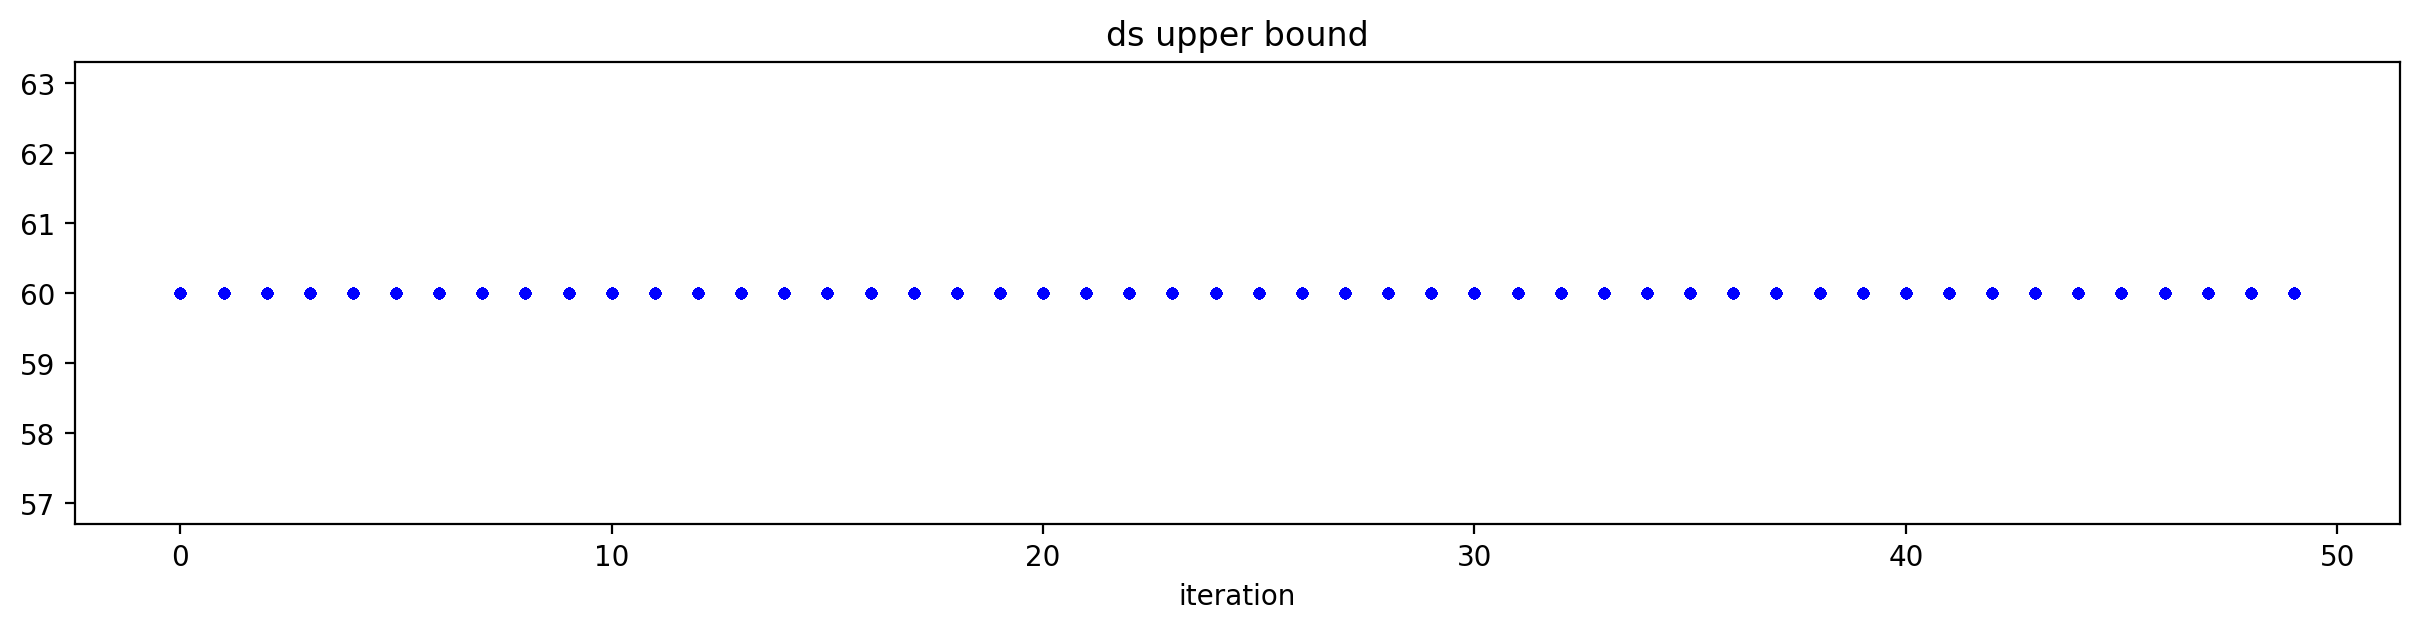

In [11]:
plt.figure(figsize=(15, 3))
plt.plot(store_ss_lower.T, ".b")
plt.xlabel("iteration")
plt.title("ss lower bound")
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(store_ss_upper.T, ".b")
plt.xlabel("iteration")
plt.title("ss upper bound")
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(store_ds_lower.T, ".b")
plt.xlabel("iteration")
plt.title("ds lower bound")
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(store_ds_upper.T, ".b")
plt.xlabel("iteration")
plt.title("ds upper bound")
plt.show()

# Plot complete model result after coupling iterations

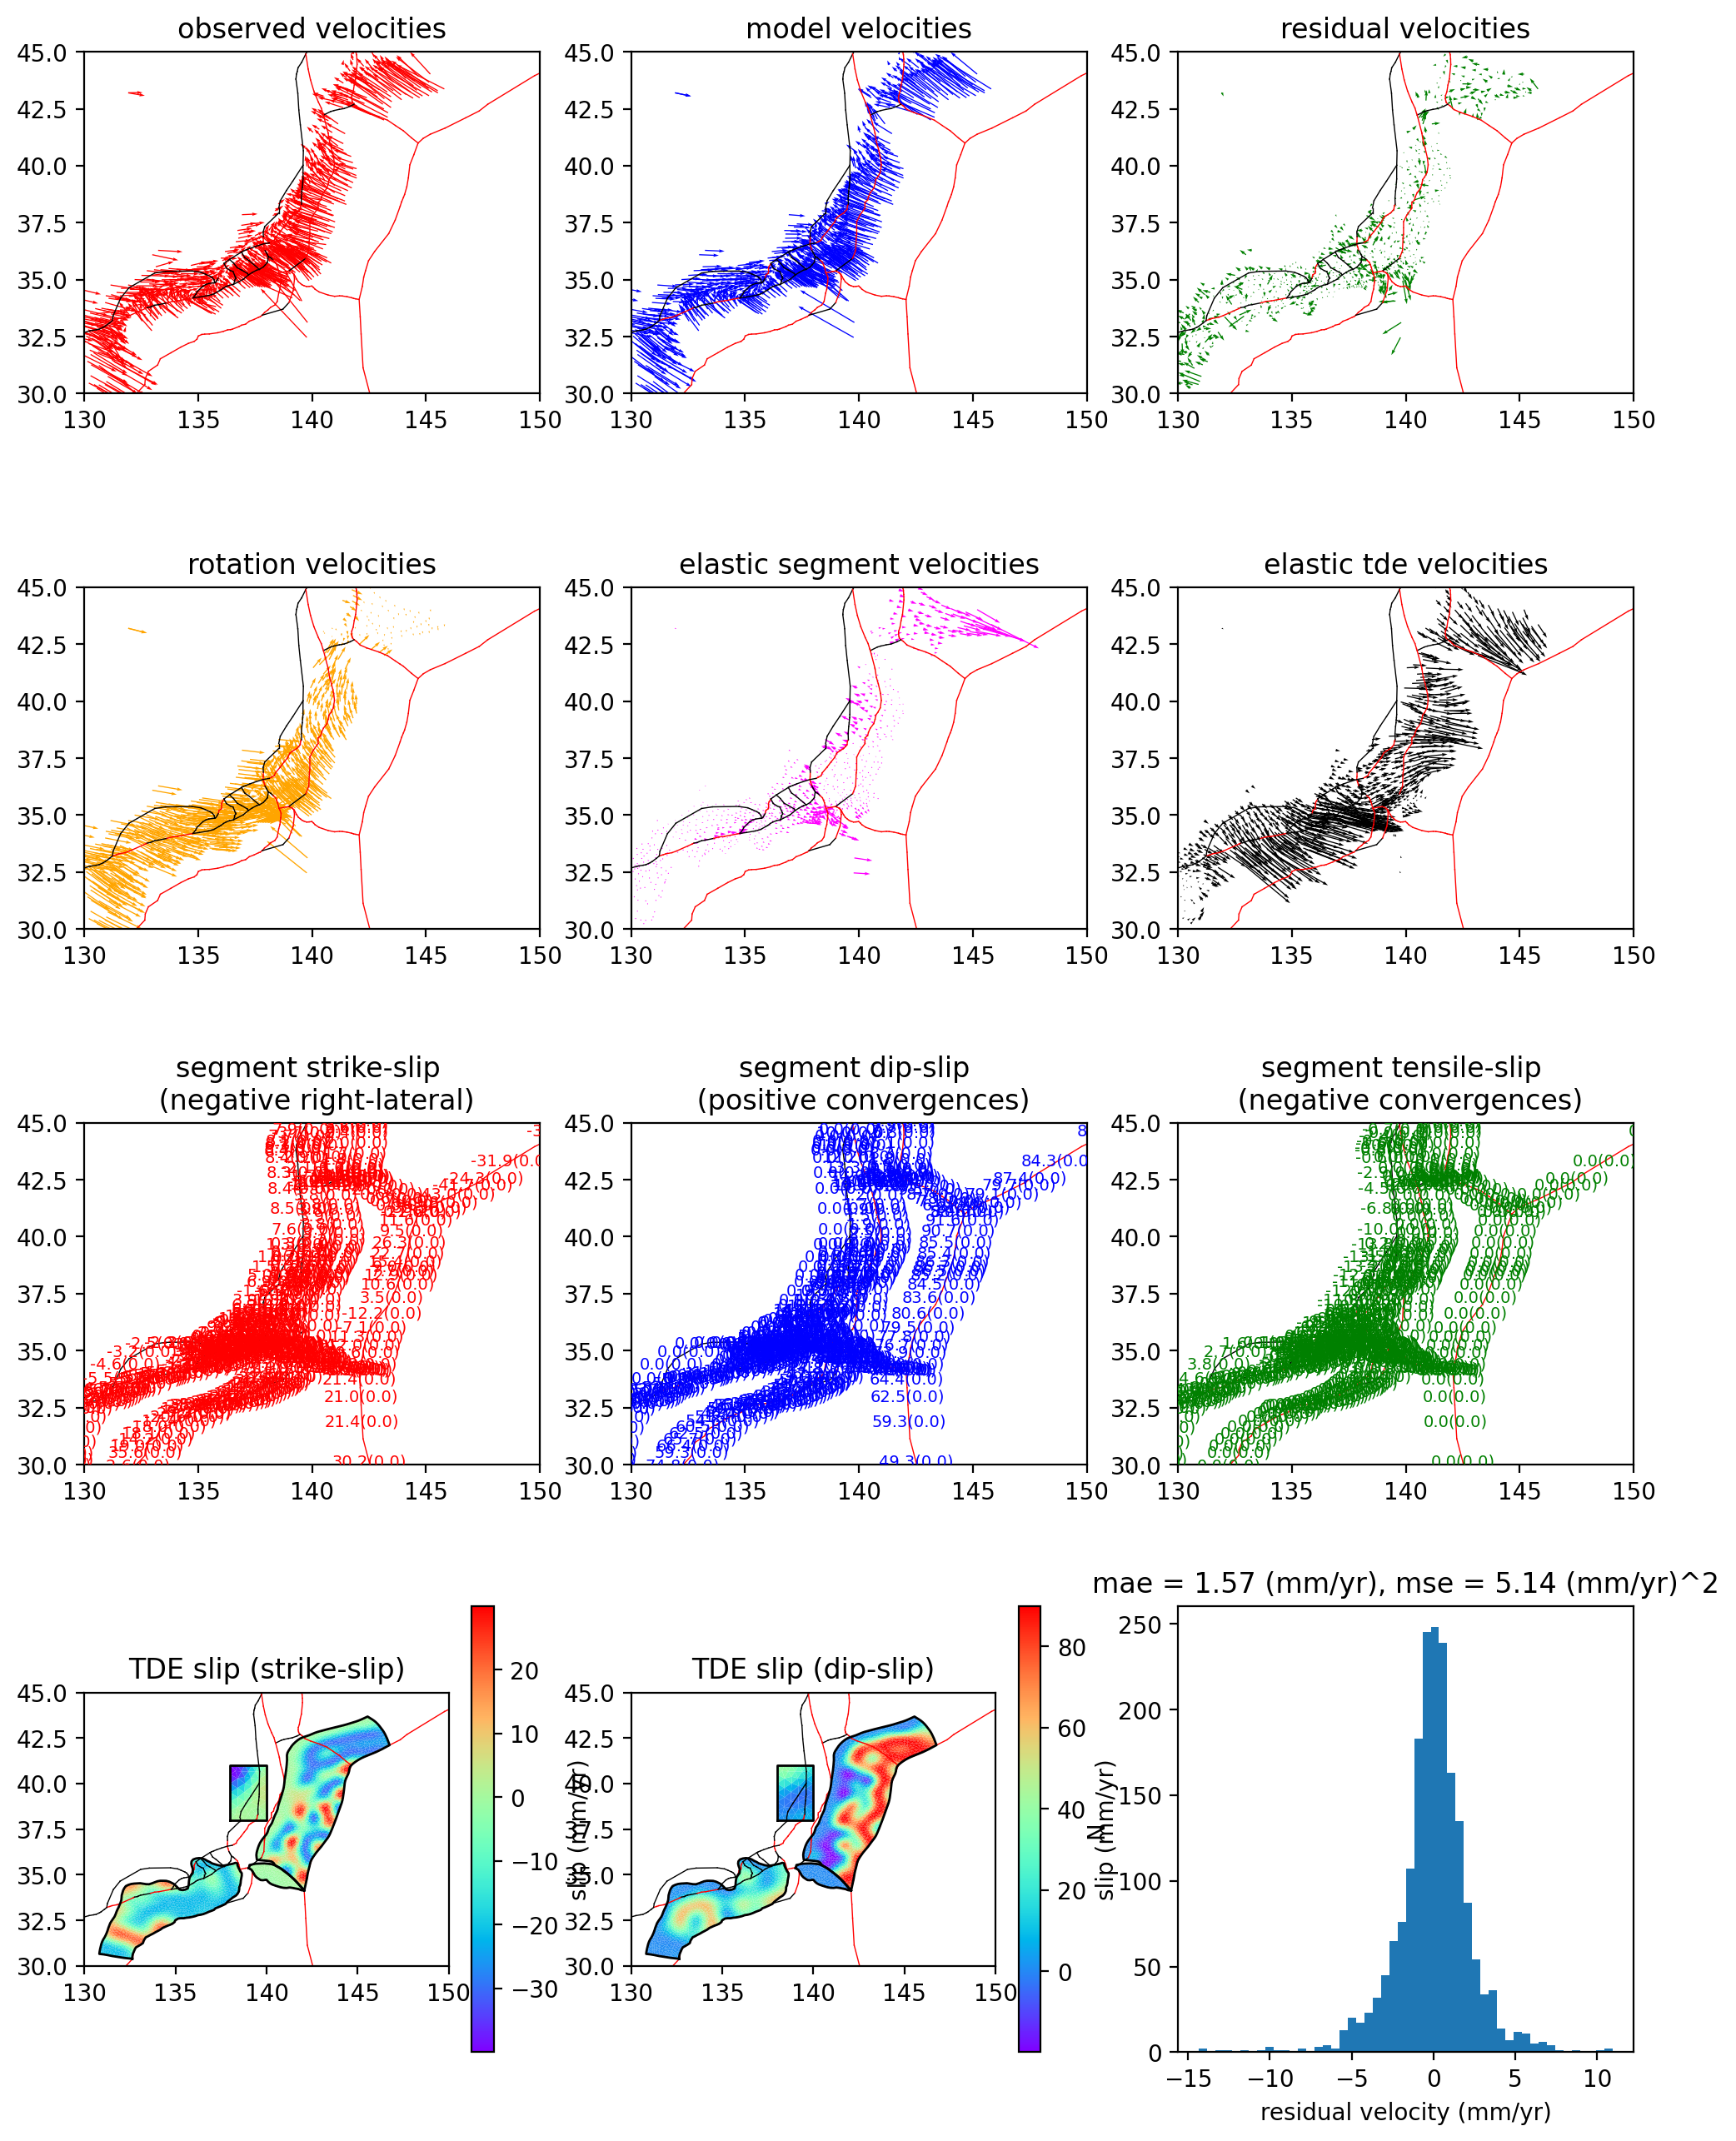

SUCCESS: Wrote figures../runs/0000000504/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6601 - 2024-11-13 18:28:20


<Figure size 640x480 with 0 Axes>

In [12]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Calculate length scales of KL modes
- FFT approach gives a garbage answer.  Need to investigate

characteristic_length_scale=0.10 (deg)


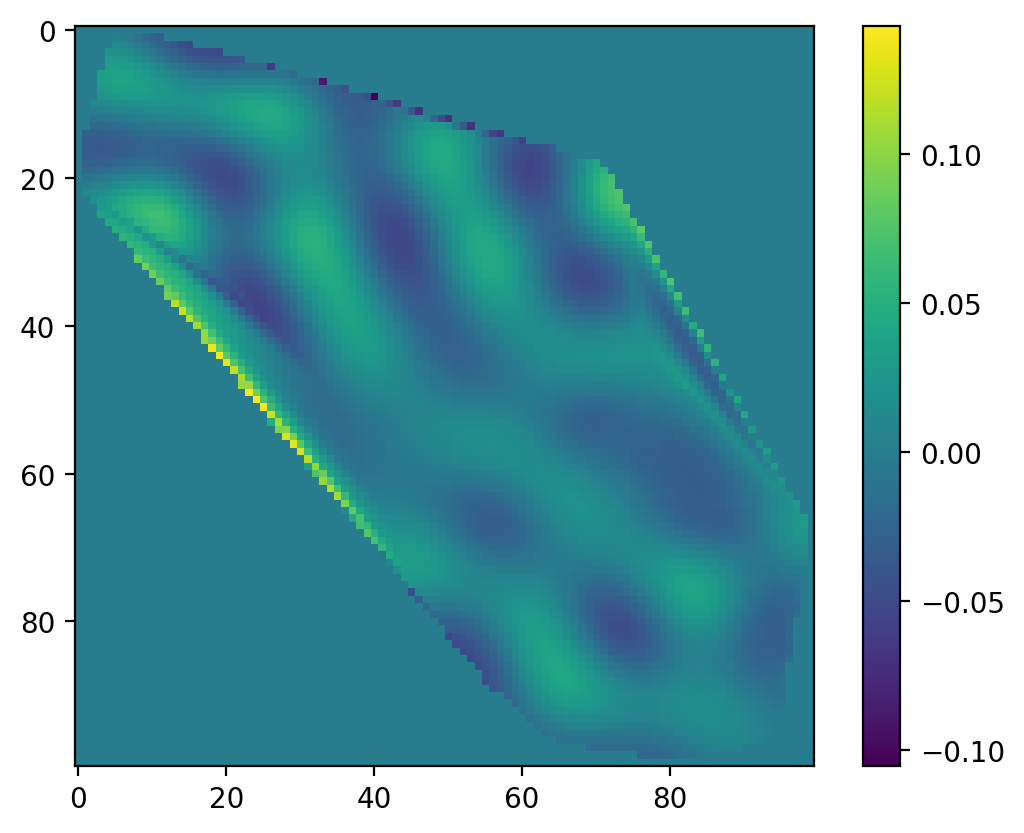

In [13]:
import numpy as np
from scipy.interpolate import griddata
from scipy.fft import fft2, fftshift


scalars = operators.eigenvectors_to_tde_slip[0][1::2, -1]
points = np.vstack((meshes[0].lon_centroid, meshes[0].lat_centroid))

x = meshes[0].lon_centroid
y = meshes[0].lat_centroid
x_min = np.min(x)
y_min = np.min(y)
x_max = np.max(x)
y_max = np.max(y)

# Step 1: Resample data onto a regular grid
# Define grid dimensions and range
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
grid_scalars = griddata(points.T, scalars, (grid_x, grid_y), method="cubic")
grid_scalars[np.isnan(grid_scalars)] = 0

# Step 2: Apply 2D Fourier Transform to the gridded data
ft = fft2(grid_scalars, norm="ortho")
ft_shifted = fftshift(ft)  # Shift zero frequency to center for visualization

# Step 3: Calculate the power spectrum (magnitude of the Fourier coefficients)
power_spectrum = np.abs(ft_shifted) ** 2

# Step 4: Identify the dominant spatial frequency
# Find the frequency with the maximum power in the spectrum
ny, nx = power_spectrum.shape
freq_x = np.fft.fftfreq(nx, d=(x_max - x_min) / nx)
freq_y = np.fft.fftfreq(ny, d=(y_max - y_min) / ny)
fx, fy = np.meshgrid(freq_x, freq_y)

# Get indices of the maximum power value (excluding zero frequency)
max_power_idx = np.unravel_index(np.argmax(power_spectrum[1:]), power_spectrum.shape)

# Convert the dominant frequency to a characteristic length scale
dominant_frequency = np.sqrt(fx[max_power_idx] ** 2 + fy[max_power_idx] ** 2)
characteristic_length_scale = 1 / dominant_frequency

print(f"{characteristic_length_scale=:3.2f} (deg)")

plt.imshow(grid_scalars)
plt.colorbar()
plt.show()

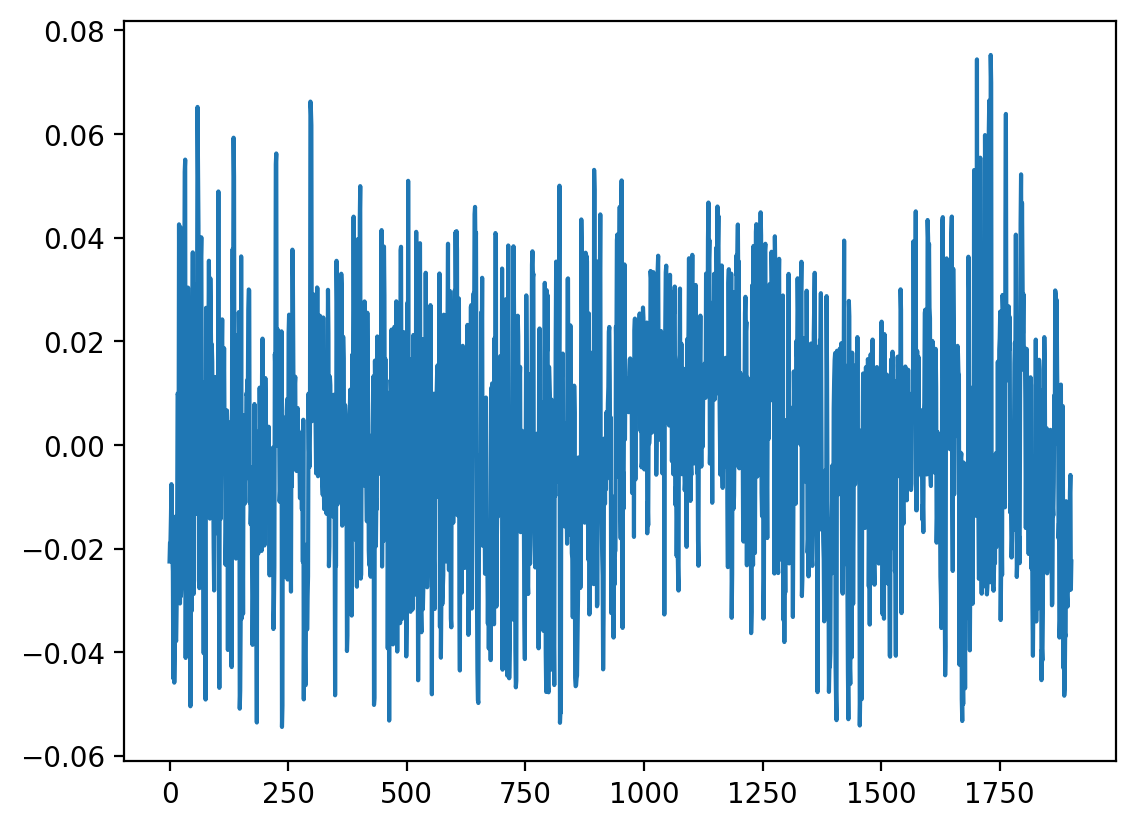

In [14]:
plt.plot(scalars)